In [3]:
import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# set up seed
RANDOM_SEED = 1

#import r
import time
import pickle
# import squarify  # for tree plot in square

# NLP packages
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# package for oversampling (SMOTE)
#from imblearn.over_sampling import SMOTE

# model metrics and scoring
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report


# cross-validation scoring code adapted from Scikit Learn documentation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
start_time = time.time()
yp_business=pd.read_json("business.json",lines=True)
print("yp_business--- %s seconds ---" % (time.time() - start_time))

yp_business--- 3.541558027267456 seconds ---


In [6]:
# check null values
print("\n unique business_id is ",yp_business['business_id'].nunique()) # each line is a unique Business
print ('\n any null value',yp_business.isnull().sum())
print(yp_business.shape)
yp_business.head(2)


 unique business_id is  192609

 any null value address             0
attributes      28836
business_id         0
categories        482
city                0
hours           44830
is_open             0
latitude            0
longitude           0
name                0
postal_code         0
review_count        0
stars               0
state               0
dtype: int64
(192609, 14)


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON


In [7]:
# look at which city the 482 businesses with missing categories are located
temp=yp_business[yp_business['categories'].isnull()]
temp=temp.groupby('city')
temp=temp.business_id.count()
temp.sort_values(ascending=False,inplace=True)
temp
#temp[temp['city']=='Scottsdale'].shape #only 13 business from Scottsdale missing categories

city
Las Vegas                   76
Phoenix                     67
Toronto                     30
Glendale                    21
Charlotte                   20
Mesa                        18
MontrÃ©al                   16
Henderson                   15
Tempe                       14
Mississauga                 14
Calgary                     13
Scottsdale                  13
Chandler                    12
Cleveland                    9
Pittsburgh                   9
North Las Vegas              8
North York                   5
Madison                      5
Concord                      4
Peoria                       4
Etobicoke                    4
Gilbert                      4
Avondale                     4
Scarborough                  3
Champaign                    3
Beloeil                      3
Huntersville                 2
Laval                        2
Willowick                    2
Monroeville                  2
                            ..
Columbia Station             1
Sto

In [116]:
# select variables for modeling
business=yp_business[['business_id','name','city','state','postal_code','stars','review_count','categories','is_open']]
business.head(2)

,business_id,name,city,state,postal_code,stars,review_count,categories,is_open
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,85016,3.0,5,"Golf, Active Life",0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",1


In [117]:
# each line is a unique Business
print("\n unique business_id is ",business['business_id'].nunique()) 
# check null values
print ('\n any null value',business.isnull().sum())


 unique business_id is  192609

 any null value business_id       0
name              0
city              0
state             0
postal_code       0
stars             0
review_count      0
categories      482
is_open           0
dtype: int64


In [118]:
#Total number of reviews associated with nan values in categories
print(business[business['categories'].isnull()]['review_count'].sum())
# 2107 reviews associated with business missing categories, small enough we can them - drop NA in categories 
business.dropna(subset=['categories'],inplace=True) 
print('unique business after droping NA in categories:',business.shape)

2107
unique business after droping NA in categories: (192127, 9)


Text(0.5, 0.98, 'Top 10 Most Reviewed Categories Lables Used')

<Figure size 1440x720 with 0 Axes>

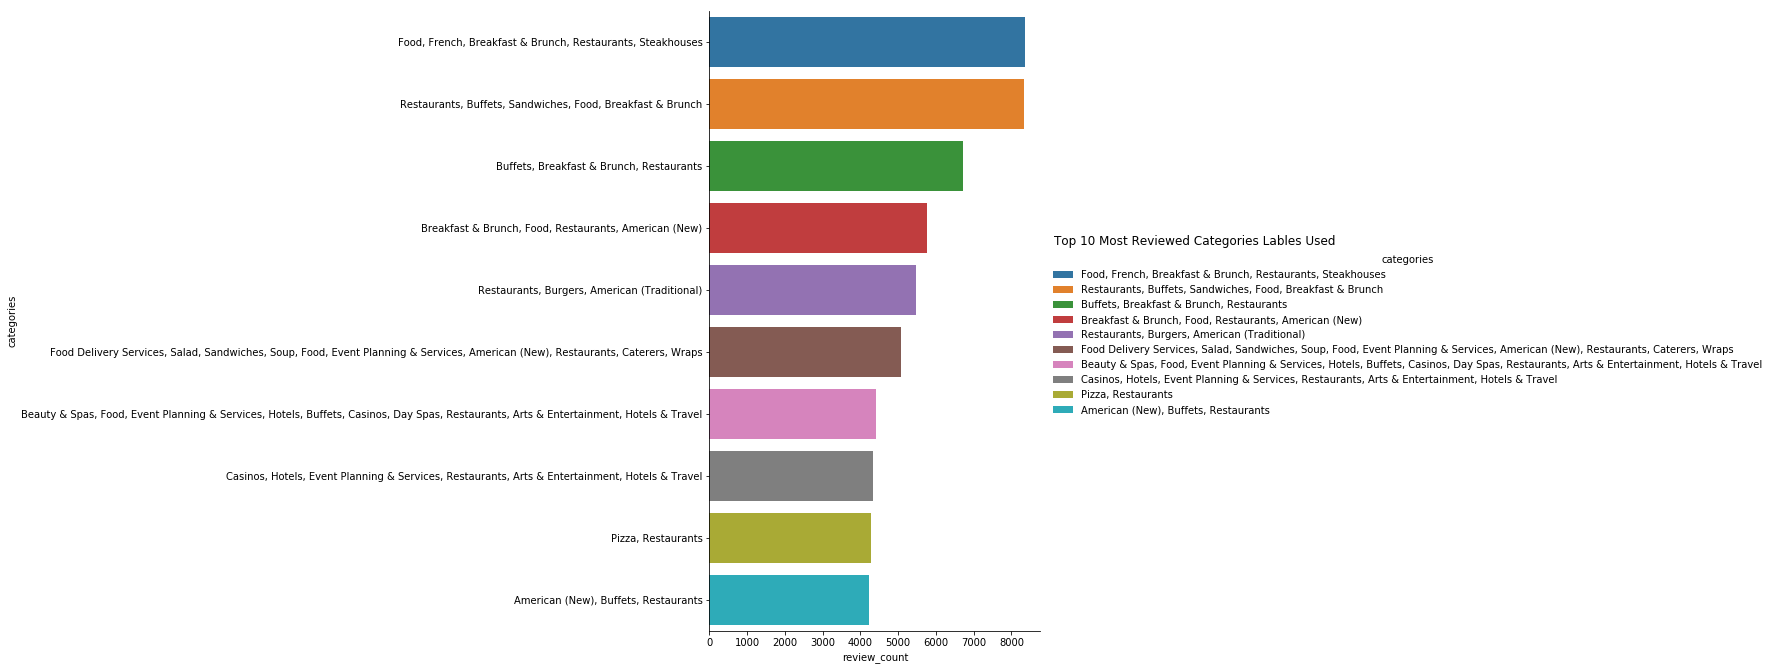

In [119]:
# Top reviewed categories are Food|food|Restanrants|Cafe|Bakery|Bar|Brunch
plt.figure(figsize=(20,10))
ax = sns.catplot(x="review_count", y="categories",data= business.nlargest(10,'review_count'), 
                 kind="bar",hue= "categories", dodge= False, height= 6)
plt.subplots_adjust(top=1.5)
ax.fig.suptitle('Top 10 Most Reviewed Categories Lables Used')

In [120]:
# convert categories to lower case so that Food and food means the samething
business["categories"]=business["categories"].str.lower()

In [121]:
# filter out business that in food restaurants business
#Food=business[business['categories'].str.contains("restaurants|food|bakery|cafe|brunch|buffets")==True]
business['cat']=business['categories'].str.contains("restaurants|food|bakery|cafe|brunch|buffets").apply(lambda x : 1 if x==True else 0)
print(business[business['cat']==1].shape) # narrow down to 74587 business for food related

(74587, 10)


In [122]:
print(business.cat.value_counts().index) # 0 means not food place
print(business.cat.value_counts().values) # narrow down to just 117540 in other business & 74587 businesses in food

Int64Index([0, 1], dtype='int64')
[117540  74587]


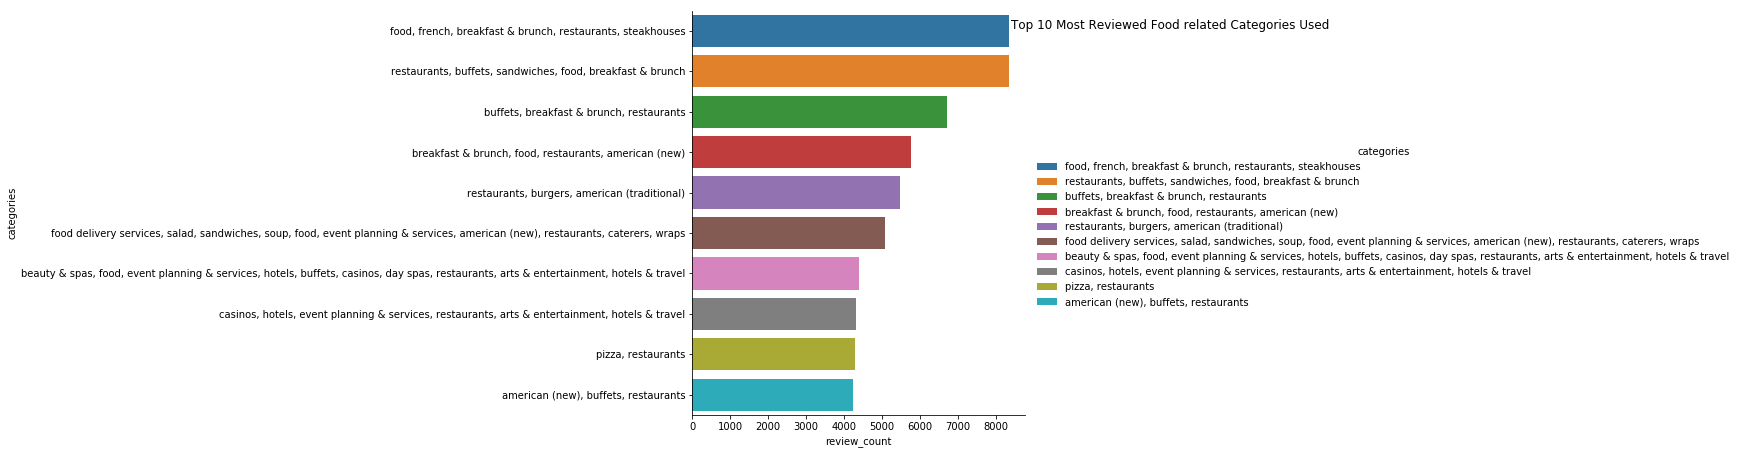

In [123]:
# Top reviewed categories are Food|food|Restanrants|Cafe|Bakery|Bar|Brunch
# look at food related business, what are the categories being reviewed the most
ax = sns.catplot(x="review_count", y="categories",data= business[business['cat']==1].nlargest(10,'review_count'), 
                 kind="bar",hue= "categories", dodge= False, height= 6 )
plt.subplots_adjust(top=1)
ax.fig.suptitle('Top 10 Most Reviewed Food related Categories Used')
plt.show()

In [124]:
#make index consistent
business.reset_index(drop=True, inplace=True)
print(business.shape)  #(192127, 10) is after the drop of na categories
business.head(2)

(192127, 10)


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,85016,3.0,5,"golf, active life",0,0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"specialty food, restaurants, dim sum, imported...",1,1


In [125]:
# define if a place is a chain store or not, do this for the whole North America, not just locale scottsdale
# check if a store name has duplicates or not, if has appeared more than once, then marked as chain store
business['chain']=business['name'].duplicated()
business['chain']=business['chain'].apply(lambda x : 0 if x==False else 1)
business.head()

,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,chain
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,85016,3.0,5,"golf, active life",0,0,0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"specialty food, restaurants, dim sum, imported...",1,1,0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,28210,4.0,170,"sushi bars, restaurants, japanese",1,1,0
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,Goodyear,AZ,85338,5.0,3,"insurance, financial services",1,0,0
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,Charlotte,NC,28217,4.0,4,"plumbing, shopping, local services, home servi...",1,0,0


### Pickle business with cat = 1 indicate food, cat = 0 indicate other business

In [47]:
# pickle file
filename = 'business'
outfile = open(filename,'wb')
pickle.dump(business,outfile)
outfile.close()

In [48]:
# load pickled file back in and check data validity if can plot
filename = 'business'
infile = open(filename,'rb')
business= pickle.load(infile)
infile.close()

In [49]:
print(business.shape)
print(business.isnull().sum()) # no na
business.head(2) #(192127, 9)
business.tail()

(192127, 11)
business_id     0
name            0
city            0
state           0
postal_code     0
stars           0
review_count    0
categories      0
is_open         0
cat             0
chain           0
dtype: int64


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,chain
192122,nqb4kWcOwp8bFxzfvaDpZQ,Sanderson Plumbing,North Las Vegas,NV,89032,5.0,9,"water purification services, water heater inst...",1,0,0
192123,vY2nLU5K20Pee-FdG0br1g,Chapters,Newmarket,ON,L3Y 6Y9,4.5,3,"books, mags, music & video, shopping",1,0,1
192124,MiEyUDKTjeci5TMfxVZPpg,Phoenix Pavers,Phoenix,AZ,85024,4.5,14,"home services, contractors, landscaping, mason...",1,0,0
192125,zNMupayB2jEHVDOji8sxoQ,Beasley's Barber Shop,Mesa,AZ,85205,4.5,15,"beauty & spas, barbers",1,0,0
192126,c1f_VAX1KIK8-JoVhjbYOw,Oriental Relax,Las Vegas,NV,89109,4.0,3,"massage, beauty & spas",0,0,0


Data note on dataframe business:
cat = 1 means food related.  cat = 0 other business; chain = 1 means the name appears more than once in the whole dataset


# A. EDA on business dataset: Target Var vs. Stars, Review_counts and City

In [50]:
# check null value
business.isnull().sum()

business_id     0
name            0
city            0
state           0
postal_code     0
stars           0
review_count    0
categories      0
is_open         0
cat             0
chain           0
dtype: int64

In [127]:
# basic statistics
business.describe()
#Comment: we see the media star of all businesses is around 3.5 and number of reviews are spread out very widly. 
# is_open is imbalaced which will be seen better in plot below

,stars,review_count,is_open,cat,chain
count,192127.000000,192127.000000,192127.000000,192127.000000,192127.000000
mean,3.589347,33.612137,0.822706,0.388217,0.247019
std,1.015462,110.263464,0.381918,0.487346,0.431279
min,1.000000,3.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,1.000000,0.000000,0.000000
50%,3.500000,9.000000,1.000000,0.000000,0.000000
75%,4.500000,25.000000,1.000000,1.000000,0.000000
max,5.000000,8348.000000,1.000000,1.000000,1.000000


[0.82270581 0.17729419]


Text(0.5, 1.0, 'Business Closure Distribution - All Cities All Businesses')

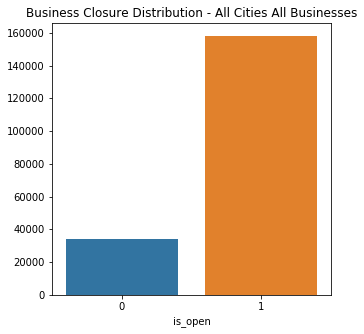

In [19]:
# we look at the proportion of target variable is_open: 82% still open and 18% is not -- imbalanced distribution
print(business['is_open'].value_counts().values/len(business['business_id'].value_counts().values))
plt.figure(figsize=(5,5))
ax=sns.countplot(x='is_open',data=business);
ax.set_ylabel('')    
plt.title("Business Closure Distribution - All Cities All Businesses")

[0.73014064 0.26985936]


Text(0.5, 1.0, 'Business Closure Distribution - All Cities Food Businesses')

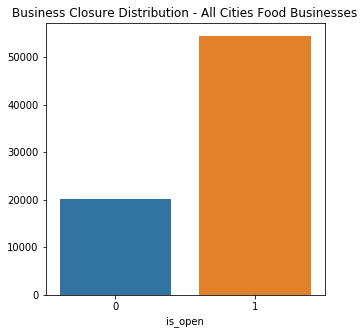

In [22]:
# filter out just food business
Food=business[business['cat']==1]
print(Food['is_open'].value_counts().values/len(Food['business_id'].value_counts().values))
plt.figure(figsize=(5,5))
ax=sns.countplot(x='is_open',data=Food);
ax.set_ylabel('')    
plt.title("Business Closure Distribution - All Cities Food Businesses")

#### Select a city as a trial point - look at which city has decent size of reviews and business_id and also has good open to close ratio

In [103]:
# plot the business count by city
by_city = business.groupby('city')


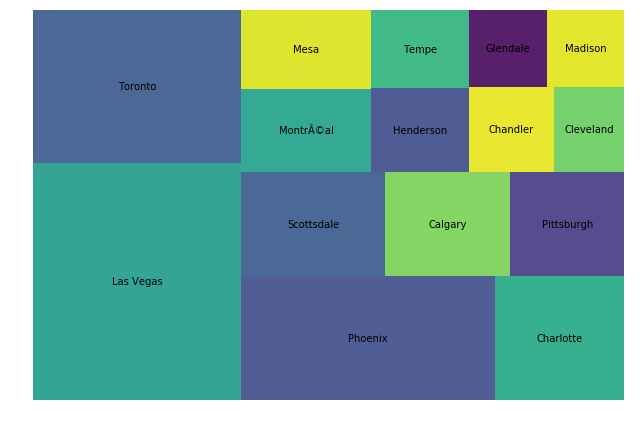

In [104]:
# plot number of business by city - top 15

import squarify    # pip install squarify (algorithm for treemap)
plt.figure(figsize=(9,6))

a = by_city['business_id'].count()

a.sort_values(ascending=False,inplace=True)

squarify.plot(sizes= a[0:15].values, label= a[0:15].index, alpha=0.9)

plt.axis('off')
plt.tight_layout()

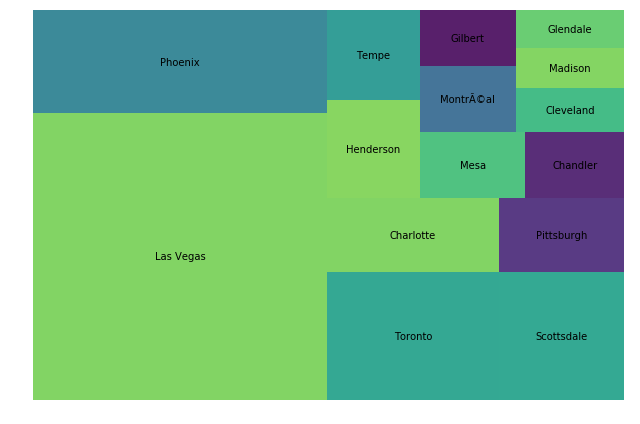

In [105]:
# plot number of review_count by city - top 15
plt.figure(figsize=(9,6))

e= by_city['review_count'].sum()

e.sort_values(ascending=False,inplace=True)

squarify.plot(sizes= e[0:15].values, label= e[0:15].index, alpha=0.9,)

plt.axis('off')
plt.tight_layout()

In [106]:
### Beside graphic, look at open to closure ratio and rank them, the lower ratio of open to close is desired
df_plot = business.groupby(['is_open', 'city']).size().reset_index().pivot(columns='is_open', index='city', values=0)
df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
df_plot['ratio']=df_plot.iloc[:,1]/df_plot.iloc[:,0]
df_plot # has lots of NaN
# drop NaN
df_plot = df_plot[np.isfinite(df_plot['total'])]
# check any NaN left?
print('any NaN left:',df_plot.isnull().sum())

#sort based on total
df_plot.sort_values(['total','ratio'],ascending=[False,False],inplace=True)
df_plot=df_plot[0:15]
df_plot.sort_values(['ratio'],ascending=[True],inplace=True)
df_plot.head()

any NaN left: is_open
0        0
1        0
total    0
ratio    0
dtype: int64


is_open,0,1,total,ratio
city,,,,
Toronto,0.242318,0.757682,18876.0,3.126804
Tempe,0.212963,0.787037,4536.0,3.695652
Madison,0.201490,0.798510,3489.0,3.963016
MontrÃ©al,0.199907,0.800093,6433.0,4.002333
Scottsdale,0.198776,0.801224,8824.0,4.030787


Text(0.5, 1.0, 'Top 15 cities with most businessed and decent data points of business closure to model')

<Figure size 720x720 with 0 Axes>

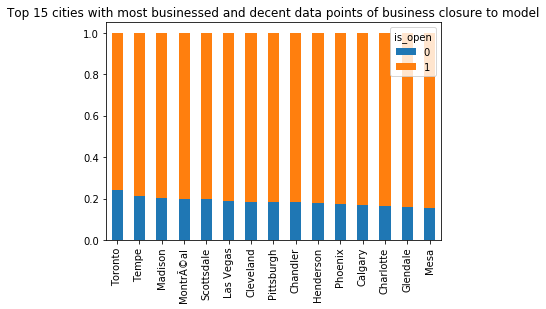

In [107]:
# plot the ratios of open to close
plt.figure(figsize=(10,10))
df_plot=df_plot.iloc[:,0:2]
ax=df_plot.plot(kind='bar', stacked=True)
# ADDED: Remove labels.
ax.set_ylabel('')    
ax.set_xlabel('')
plt.title("Top 15 cities with most businessed and decent data points of business closure to model")

In [108]:
## another way is to rank by review counts and business_id
d = {'review_count': ['sum'],'business_id':['count']}
city= business.groupby(['city']).agg(d)
city.columns = ['_'.join(col) for col in city.columns.values]
city = city.reset_index(drop=False)
city.sort_values(['review_count_sum','business_id_count'],ascending=False,inplace=True)
city.head(10)

,city,review_count_sum,business_id_count
450,Las Vegas,1965328,29294
779,Phoenix,706470,18699
1064,Toronto,510740,18876
958,Scottsdale,372754,8824
162,Charlotte,299161,9489
800,Pittsburgh,218737,7008
370,Henderson,210535,4877
1053,Tempe,195012,4536
567,Mesa,161754,6062
156,Chandler,151135,4297


In [101]:
# look at target var at all cities level but separate food from non food
allcity_food=business[business['cat']==1]['business_id']
allcity_nonFood=business[business['cat']==0]['business_id']

Text(0.5, 1.0, 'business closure distribution_non-food business_all cities')

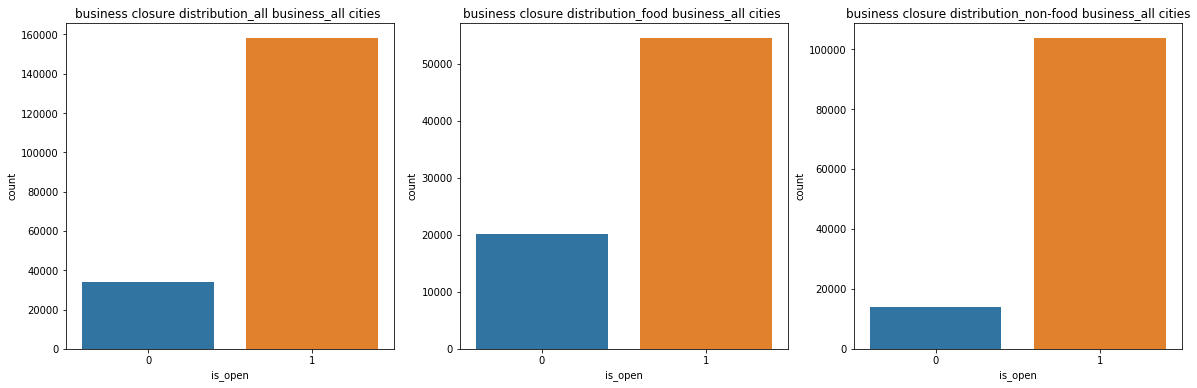

In [102]:
# plot is_open , all cities, separate for all bus., food, non-fod
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.countplot(x='is_open',data=business);
plt.title("business closure distribution_all business_all cities ")
plt.subplot(1,3,2)
#plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=business[business['cat']==1]);
plt.title("business closure distribution_food business_all cities ")
plt.subplot(1,3,3)
sns.countplot(x='is_open',data=business[business['cat']==0]);
plt.title("business closure distribution_non-food business_all cities")

In [128]:
#business_id for city == Toronto

#business categories is food
city='Scottsdale'#'Tempe' #'Toronto'
#business=business[business['cat']==1]
business=business[business['city']==city]  # change City of analysis: Tempe, Toronto;Scottsdale

bus_id=business['business_id']
len(bus_id) #8824 for all businesses in Scottsdale
# Tempe: 1342 food places which is 30% of 4536 all business; Scottsdale:2004 food places is 22% of 8824 all business; 
# Toronto

8824

Text(0.5, 1.0, 'business closure distribution for non-food business Scottsdale')

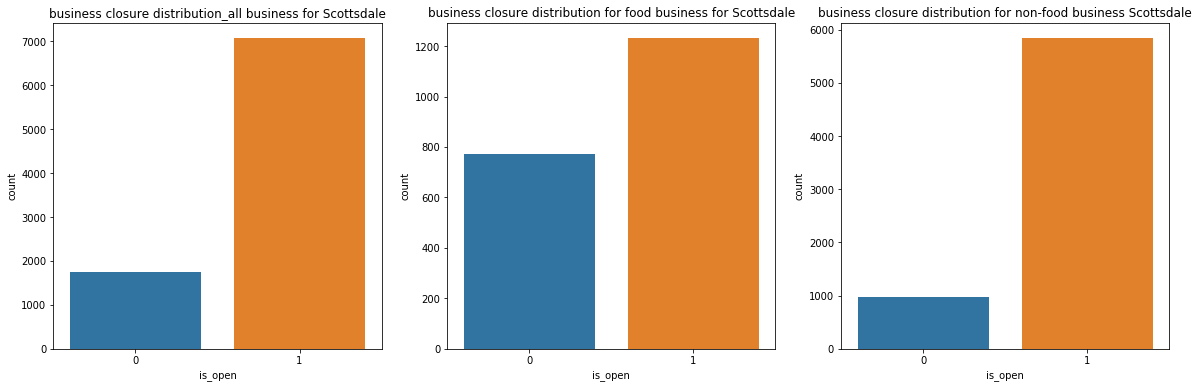

In [24]:
# plot is_open for food, non food and total bus for selected city
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.countplot(x='is_open',data=business);
plt.title("business closure distribution_all business for %s" % city)
plt.subplot(1,3,2)
#plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=business[business['cat']==1]);
plt.title("business closure distribution for food business for %s" % city)
plt.subplot(1,3,3)
sns.countplot(x='is_open',data=business[business['cat']==0]);
plt.title("business closure distribution for non-food business %s" % city)

In [69]:
## find color for plot
#current_palette = sns.color_palette()
#sns.palplot(current_palette)
#sns.palplot(sns.color_palette("Blues"))

### Further narrow down to Scottsdale Food

In [129]:
# Further narrow down to Scottsdale Food
city='Scottsdale'#'Tempe' #'Toronto'
business=business[business['cat']==1]
business=business[business['city']==city]  #
# business list on Scottsdale Food
business.city.value_counts().index #check if working on the right city
#bus_id=business[business['cat']==1].business_id
bus_id=business['business_id']
len(bus_id)

2004

Text(0.5, 0, 'Ratings ')

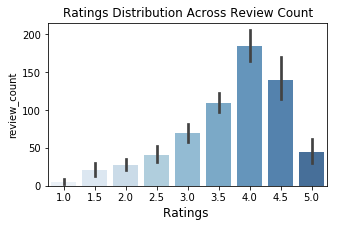

In [54]:
plt.figure(figsize=(5,3))
ax= sns.barplot(x = 'stars', y='review_count',data= business ,alpha=0.8,palette="Blues" )
plt.title("Ratings Distribution Across Review Count")
plt.xlabel('Ratings ', fontsize=12)
#Comment: most reviews are associated with 4 stars. Surprisinglly not many 5 star reviews 

Text(0.5, 0, 'Ratings ')

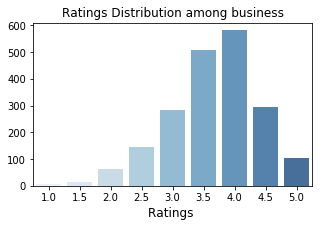

In [55]:
x = business['stars'].value_counts().index
y = business['stars'].value_counts().values  #count unque value of a star - star frequency by business_id 
plt.figure(figsize=(5,3))
ax= sns.barplot(x, y,data= business ,alpha=0.8,palette="Blues" )
plt.title("Ratings Distribution among business")
plt.xlabel('Ratings ', fontsize=12)

# Comment: most businesses are rated between 3.5 to 4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025F27F939B0>,
      dtype=object)

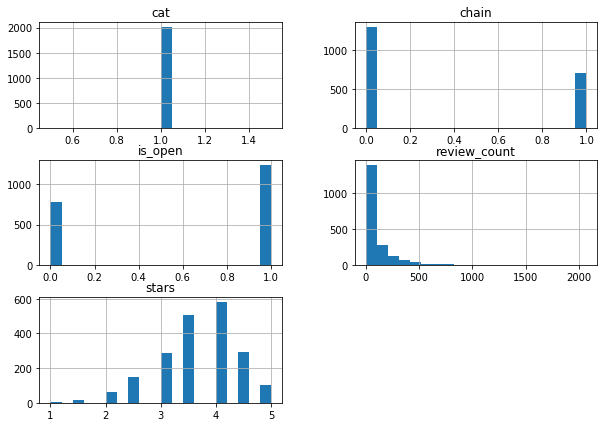

In [56]:
#  do this with sentiment too
business.hist(bins=20,figsize=(10,7)) #figsize=(9,6)

Note - 
business dataframe is Scottsdale Food only and has flag "cat" for food, "chain" for chain store

In [115]:
business.head(2)

,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,...,latest_x,age_x,flag_tip_sum,stars_mean_y,sentiment_mean_y,polarity_mean_y,sentiment_type_sum_y,earliest_y,latest_y,age_y
0,q2KtxnPa6rPSpAlMbg9l8g,Nothing Bundt Cakes,Scottsdale,AZ,85255,4.0,174,"desserts, food, cupcakes, bakeries",1,1,...,2018,3593,30.0,4.227273,0.282586,0.582635,95,2009,2018,3593
1,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,AZ,85257,3.5,526,"seafood, restaurants",1,1,...,2018,4681,65.0,3.574586,0.261690,0.576045,291,2006,2018,4681


In [130]:
# pickle file
filename = 'business_Scottsdale_Food'
outfile = open(filename,'wb')
pickle.dump(business,outfile)
outfile.close()

# C. EDA on Tip dataset and get tip counts

In [58]:
# load JSON tip file
yp_tip=pd.read_json("tip.json",lines=True)
print(yp_tip)
yp_tip.head(2)

,business_id,compliment_count,date,text,user_id
0,VaKXUpmWTTWDKbpJ3aQdMw,0,2014-03-27 03:51:24,"Great for watching games, ufc, and whatever el...",UPw5DWs_b-e2JRBS-t37Ag
1,OPiPeoJiv92rENwbq76orA,0,2013-05-25 06:00:56,Happy Hour 2-4 daily with 1/2 price drinks and...,Ocha4kZBHb4JK0lOWvE0sg


In [106]:
# select var
tip=yp_tip[['business_id','date','text','user_id']]
print(tip.shape)

# filter out just Scottsdale Food
tip = tip.loc[tip['business_id'].isin(bus_id)] 
tip.shape

(1223094, 4)


(47734, 4)

In [99]:
tip['date']=tip['date'].astype(str).str[:10]
tip.isnull().sum() 

business_id    0
date           0
text           0
user_id        0
dtype: int64

In [100]:
tip['flag_tip']=1

In [101]:
tip.head(2)

,business_id,date,text,user_id,flag_tip
28,p-8AMN9Q0qwym-3Pdle20Q,2017-03-10,Good mix of cuisine,r64WY53LOMRPowHDu2JIXw,1
51,6sKaAF8WhWyyCjfZr2Rfsg,2011-04-07,Last time... =(,330erZ8TCzA2eoexQMATBg,1


In [102]:
# count number of tips left by customers per each business_id
d = {'flag_tip': ['sum']}
tip_count= tip.groupby(['business_id']).agg(d)

# flatten MultiIndex columns
tip_count.columns = ['_'.join(col) for col in tip_count.columns.values]
tip_count = tip_count.reset_index(drop=False)
tip_count.head(2)

,business_id,flag_tip_sum
0,-01XupAWZEXbdNbxNg5mEg,22
1,-4TMQnQJW1yd6NqGRDvAeA,52


In [107]:
# merge flag_tip_sum to tip
tip=pd.merge(tip, tip_count,on='business_id',how='left')
print(tip.shape)
tip.head(2)

(47734, 5)


,business_id,date,text,user_id,flag_tip_sum
0,p-8AMN9Q0qwym-3Pdle20Q,2017-03-10 19:32:16,Good mix of cuisine,r64WY53LOMRPowHDu2JIXw,136
1,6sKaAF8WhWyyCjfZr2Rfsg,2011-04-07 01:04:16,Last time... =(,330erZ8TCzA2eoexQMATBg,156


## Text analysis on tip

In [182]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JayZ2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [183]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JayZ2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [184]:
# create a bag of words consisting of all the tips
start_time = time.time()
a =tip['text'].str.lower().str.cat(sep=' ')
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 0.25197863578796387 seconds ---


In [185]:
a[0:1000]

'good mix of cuisine last time... =( the iced kicker is a must, and if you have little ones a chocolate milk with whip cream. seats were good. food was ok. decent drinks. better than a regular movie. late nights are best for quick service and patio table veggie no special sauce with fries as meat - v e g a n!!! try the bavarian pretzel appetizer... awesome! happy hour 3 pm to 630 pm m-f bye-bye starbucks!  it\'s now a saladworks. very cool place. ! many vegetarian options, even veg and tofu spring rolls! great food super cute spot for lunch or dinner. brussels sprouts and cauliflower are delish! bears. come by in the late afternoons to redeem those treat receipts from the morning and get one ice grande drink for $2.00!  the place is empty. brunch with the love of my life! wow that rice pudding is terrific!  and is sprinkled with crushed pistachios.  and "the bob"  little pastry is soooo good great burgers but amazing salads here google maps is off slightly, the great indoors is near lo

In [186]:
import re
start_time = time.time()
b = re.sub('[^A-Za-z]+', ' ', a) #Regular Expressions in Python:checks if the input from the user contains only letters
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 0.2772393226623535 seconds ---


In [187]:
# create stop words list
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords)
stop_words.extend(nltk_words)

In [191]:
start_time = time.time()
word_tokens = word_tokenize(b)
print("word token length :",len(word_tokens))
print("runtime: --- %s seconds ---" % (time.time() - start_time))

word token length : 520704
runtime: --- 1.322779893875122 seconds ---


In [192]:
    start_time = time.time()
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    print("filtered_sentence length:",len(filtered_sentence))
    print("runtime: --- %s seconds ---" % (time.time() - start_time))

filtered_sentence length: 315702
runtime: --- 1.228360652923584 seconds ---


In [193]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()] 

Text(0.5, 1.0, 'Most Frequently Used Words in Tips in Scottsdale Food')

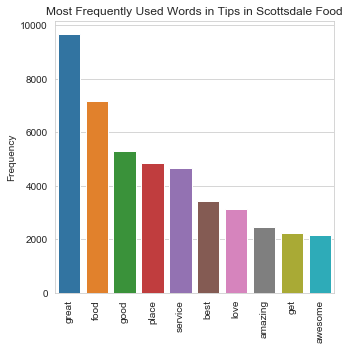

In [205]:
# the most frequently used words in the tips
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)

rslt = pd.DataFrame(word_dist.most_common(top_N),columns=['Word', 'Frequency'])

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(10))
plt.xticks(rotation=90)
#ax.set_ylabel('')    
ax.set_xlabel('')
plt.title("Most Frequently Used Words in Tips in %s Food"%city)

In [196]:
rslt [0:10]

,Word,Frequency
0,great,9680
1,food,7170
2,good,5300
3,place,4837
4,service,4658
5,best,3418
6,love,3143
7,amazing,2457
8,get,2234
9,awesome,2160


In [200]:
# word cloud
from wordcloud import WordCloud, STOPWORDS
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

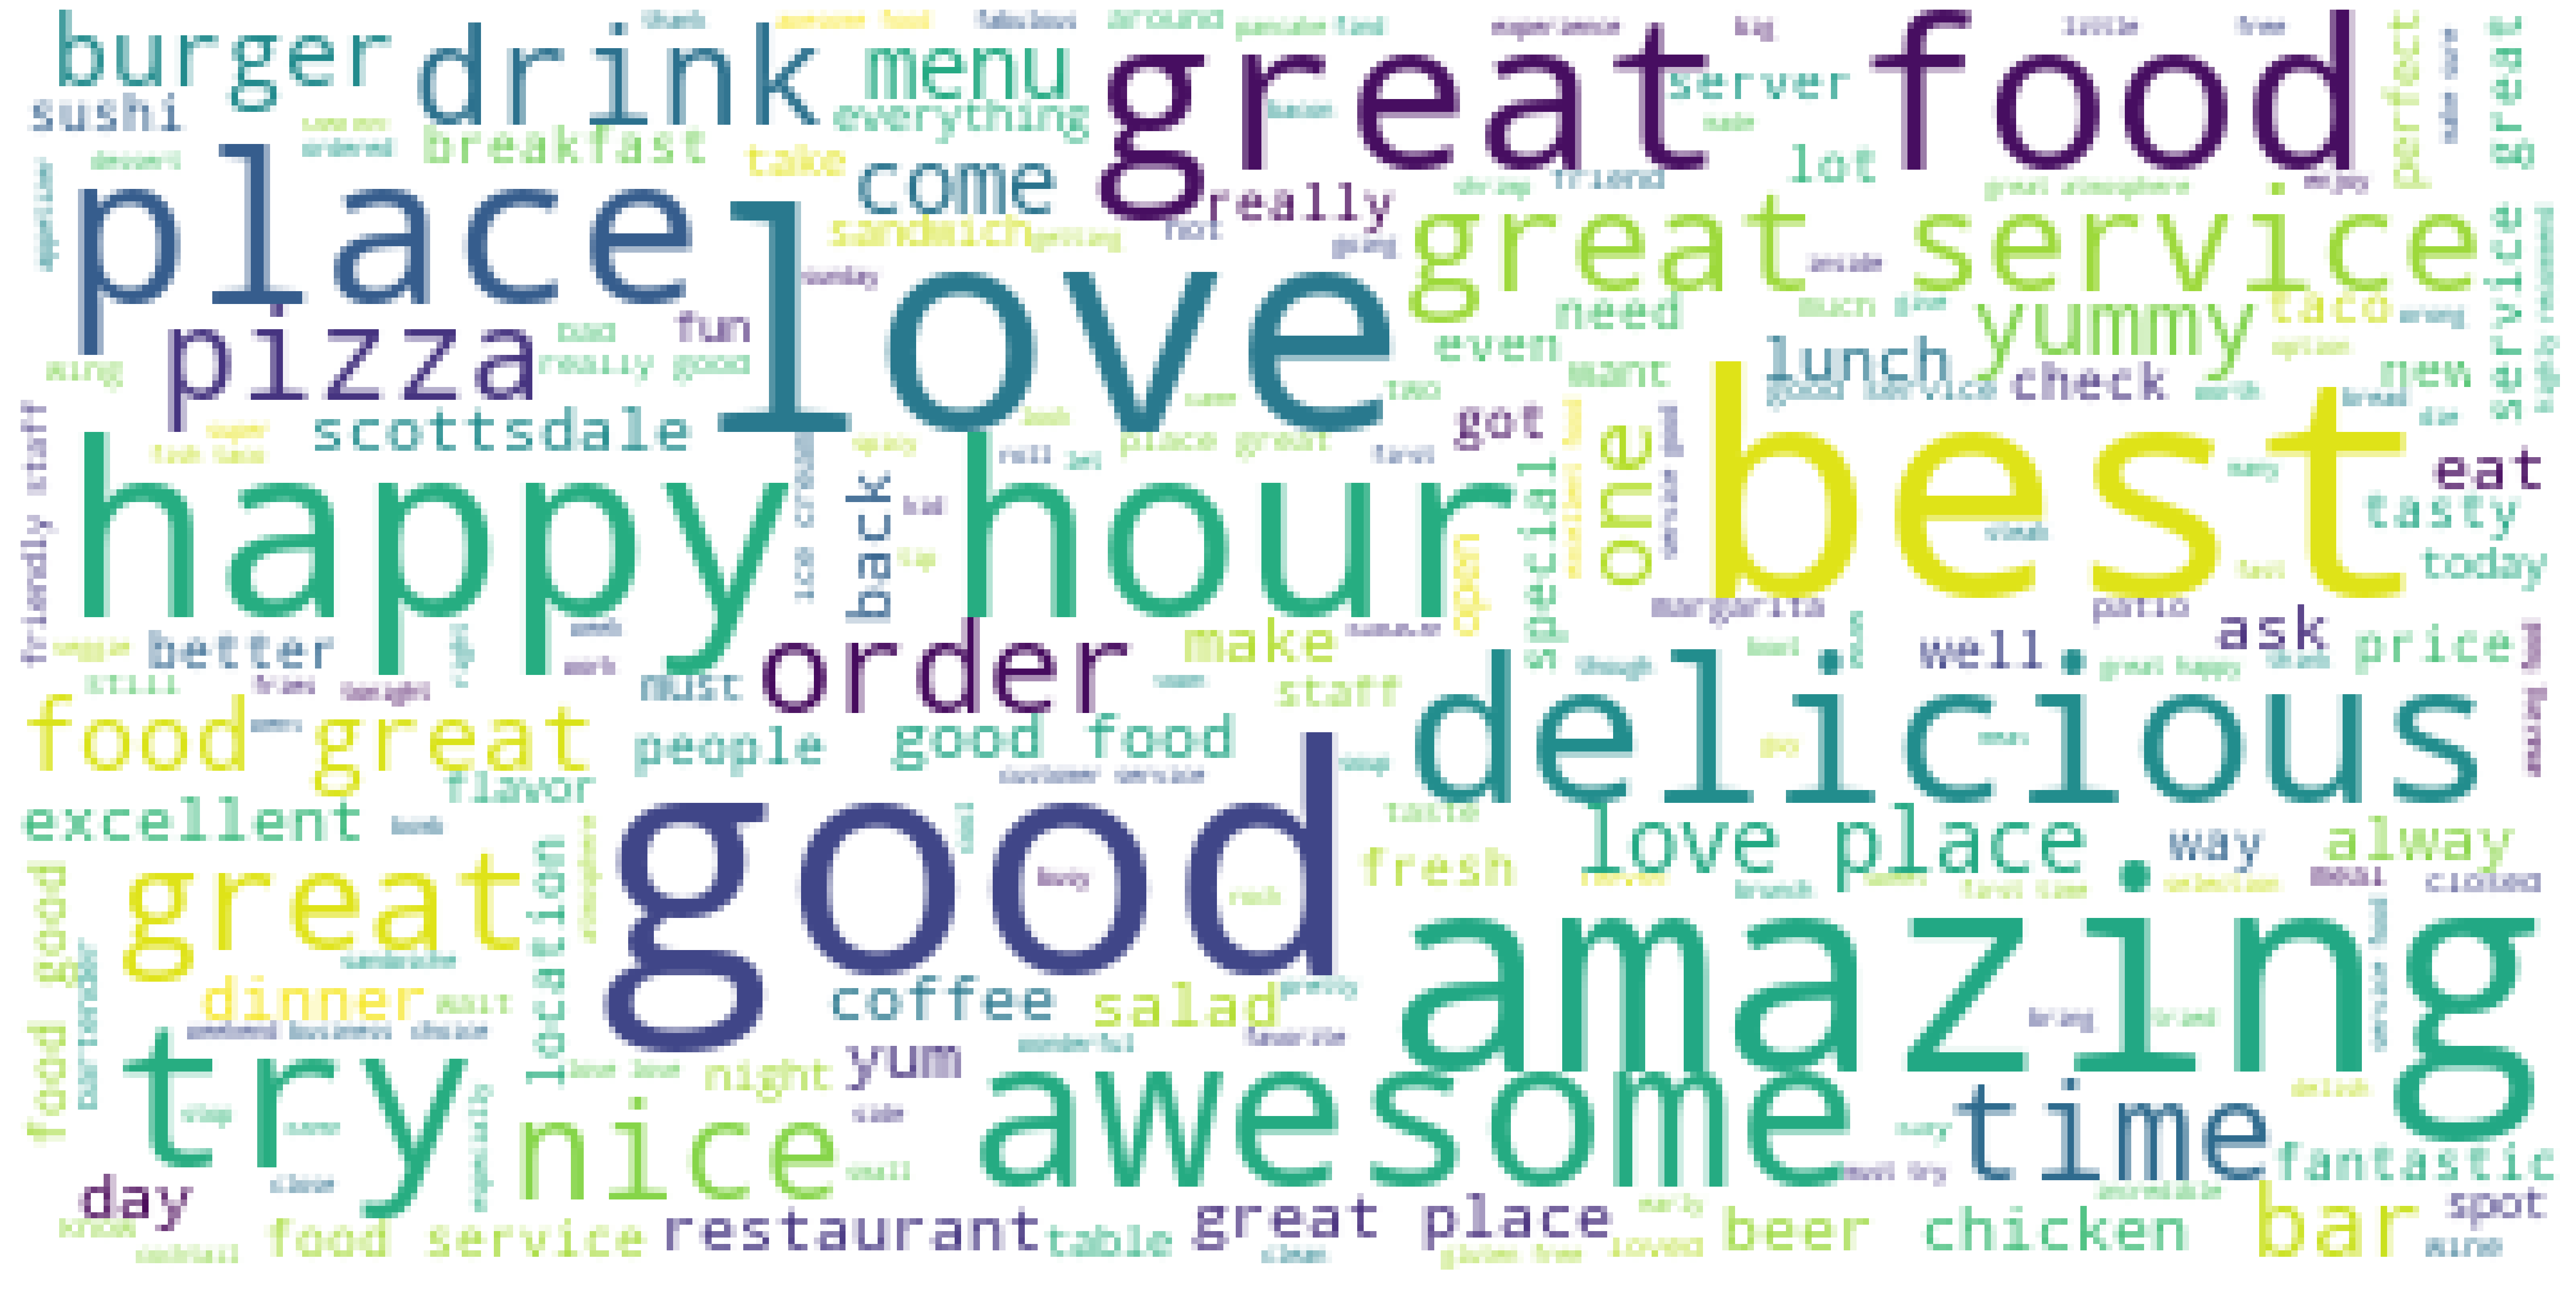

In [203]:
wc(cleaned_data_title,'white','Most Used Words')

## Sentiment analysis on tip

In [108]:
# sentiment analysis on tip
tip_sentiment=tip.iloc[:,[0,2]]
print(tip_sentiment.shape)
tip_sentiment.tail(2)

(47734, 2)


,business_id,text
47732,L192hPeosT4Z1qRO8jQbfQ,Cuban pork sandwich and a Spaten. Good times!
47733,wEc4JE2NYQr1RnGjGr4q7w,Jess is the best bartender!! Go check her out!


In [109]:
#analysis on the entire review rather than all the words.
df_tip_str=tip_sentiment['text'].astype(str)
print(df_tip_str.shape) #(1223094,) for all Tips.  (47734,) for Scottsdale Food places

(47734,)


In [110]:
df_tip_str[0:10] 

0                                  Good mix of cuisine
1                                      Last time... =(
2    The iced kicker is a must, and if you have lit...
3    Seats were good. Food was ok. Decent drinks. B...
4    Late nights are best for quick service and pat...
5    Veggie no special sauce with fries as meat - V...
6       Try the bavarian pretzel appetizer... Awesome!
7                        Happy hour 3 PM to 630 PM M-F
8    Bye-bye Starbucks!  It's now a Saladworks. Ver...
9    Many vegetarian options, even veg and tofu spr...
Name: text, dtype: object

In [111]:
import pickle
filename = 'df_tip_str'
outfile = open(filename,'wb')
pickle.dump(df_tip_str,outfile)
outfile.close()

In [112]:
len(set(tip['business_id']))# 123997 unique business therefore need to sum up flag_tip to get # tips per business
# it reduces to 1783 for Scottsdale Food

1783

In [ ]:
#####################################################
####### MOVE THIS RUN TO GOOGLE COLAB ###############
####################################################

from textblob import TextBlob

bloblist_desc = list()

start_time = time.time() 

for row in tip_str:
    
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])
print("runtime: --- %s seconds ---" % (time.time() - start_time))

In [132]:
## get pickled file from Google Colab drive
## load in pickled file to see sentiment score
filename = 'df_polarity_desc_tip'
infile = open(filename,'rb')
df_polarity_desc_tip= pickle.load(infile)
infile.close()

df_polarity_desc_tip.head(2)

,Review,sentiment,polarity,Sentiment_Type
0,Good mix of cuisine,0.700000,0.600000,1
1,Last time... =(,-0.375000,0.533333,-1
2,"The iced kicker is a must, and if you have lit...",-0.187500,0.500000,-1
3,Seats were good. Food was ok. Decent drinks. B...,0.373333,0.468718,1
4,Late nights are best for quick service and pat...,0.344444,0.466667,1


In [133]:
# sepearately look at postive negative reviews
positive_tips=df_polarity_desc_tip[df_polarity_desc_tip['Sentiment_Type']==1]
negative_tips=df_polarity_desc_tip[df_polarity_desc_tip['Sentiment_Type']==-1]

In [134]:
# Define world cloud
from wordcloud import WordCloud, STOPWORDS
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

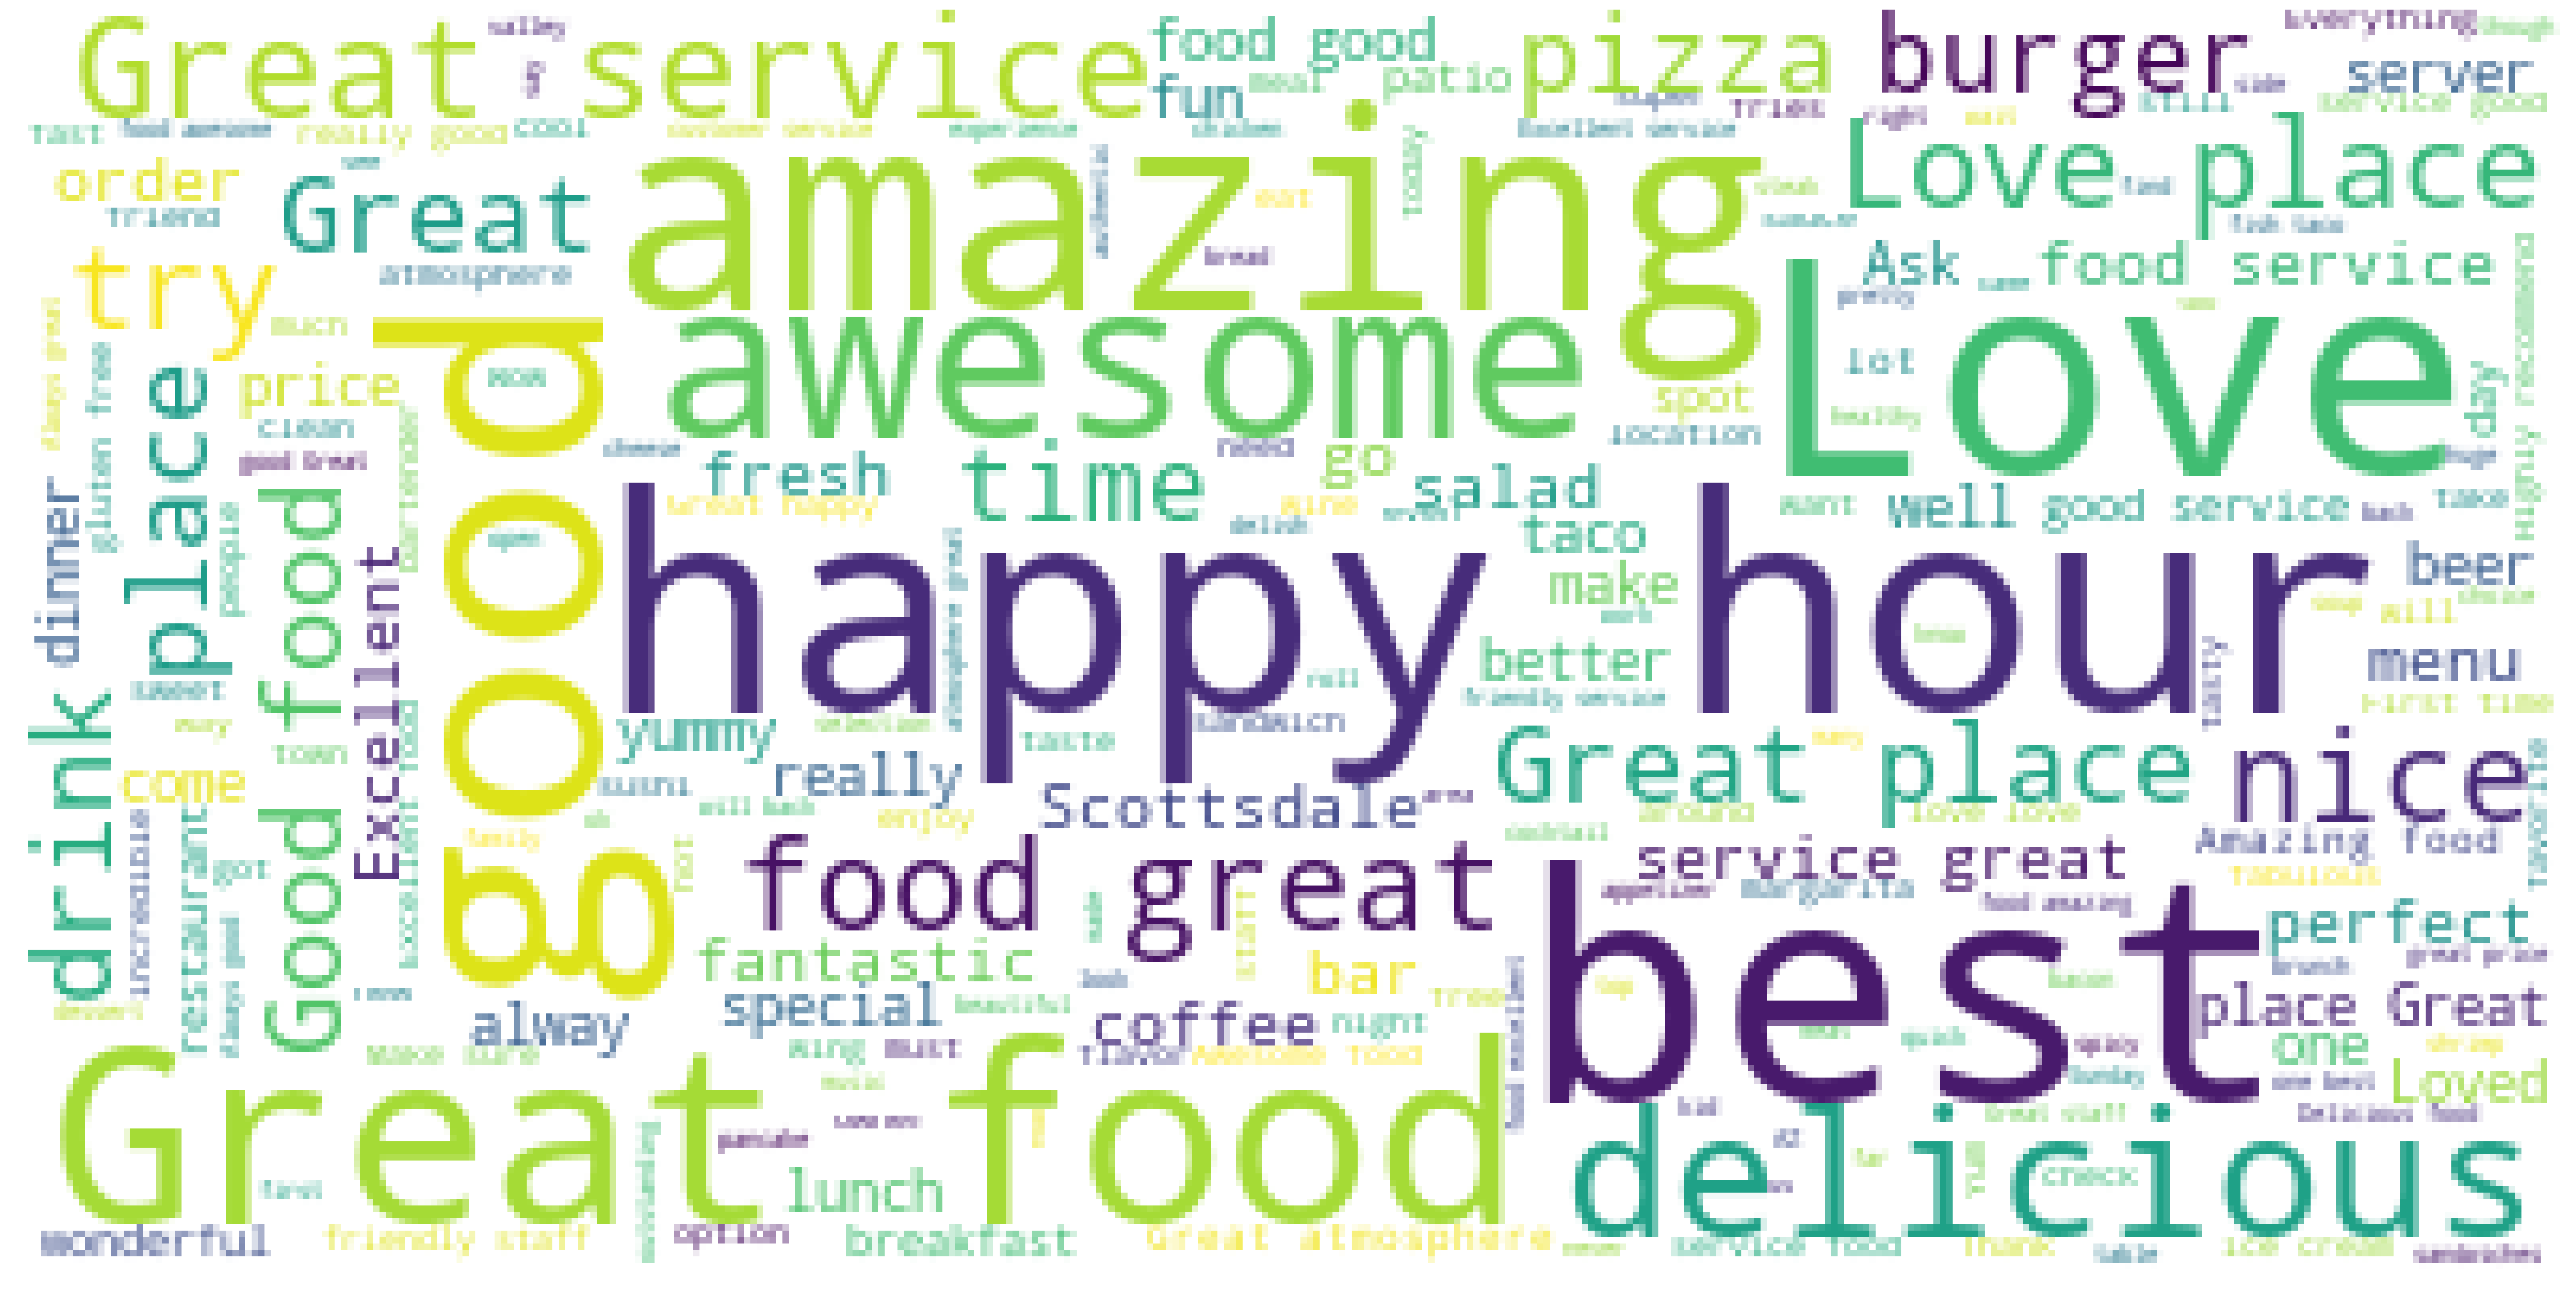

In [137]:
wc(positive_tips['Review'],'white','Most Used Words')  # too similar to review world cloud. may not use it

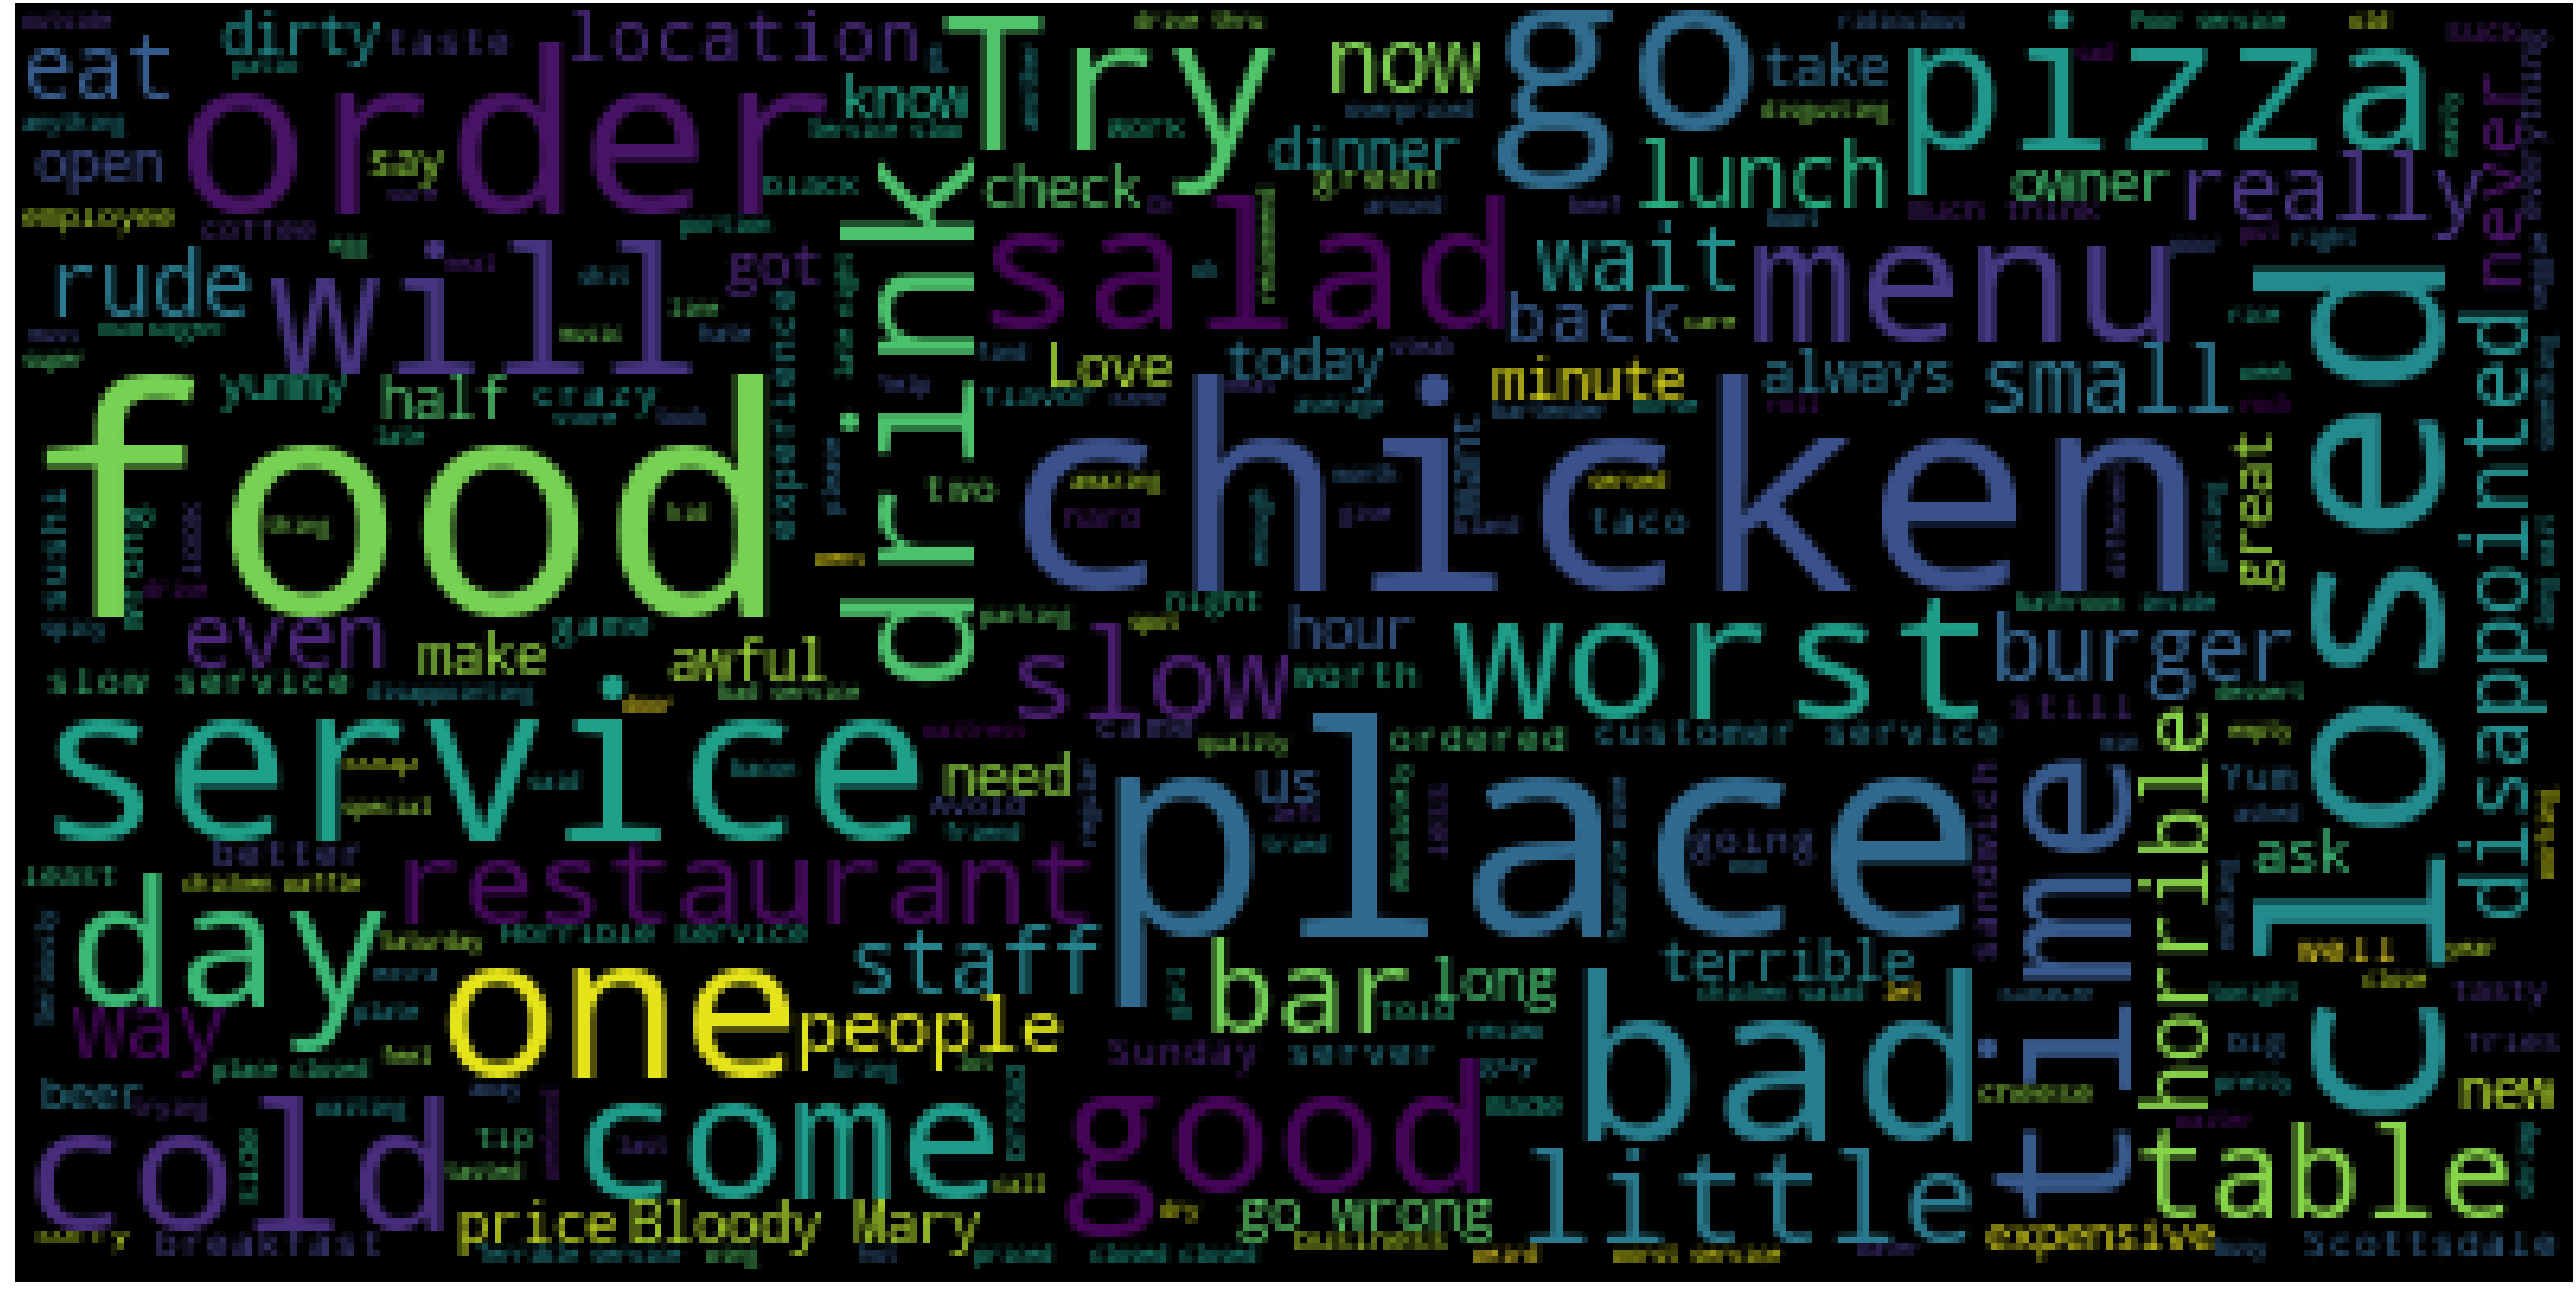

In [135]:
wc(negative_tips['Review'],'black','Most Used Words') ## Not very helpful for tip analysis


In [145]:
tip['flag_tip']=tip['flag_tip_sum'].apply(lambda x : 0 if x==0 else 1)
tip.tail(3) # index is sorted

,business_id,date,text,user_id,flag_tip_sum,flag_tip
47731,vrZ5N1CQc72Wji3rPkYCCg,2012-08-22 04:16:19,"Wow, everything was incredible, including our ...",ykEGuslC8VCq4wRuSOodRA,19,1
47732,L192hPeosT4Z1qRO8jQbfQ,2010-10-16 19:45:29,Cuban pork sandwich and a Spaten. Good times!,lohmi3v7xQOwM-oxuJPSUg,147,1
47733,wEc4JE2NYQr1RnGjGr4q7w,2018-10-02 03:34:58,Jess is the best bartender!! Go check her out!,HtLaONYabidSxMS1eGHcXA,94,1


In [144]:
df_polarity_desc_tip.head(2)

,Review,sentiment,polarity,Sentiment_Type
0,Good mix of cuisine,0.700,0.600000,1
1,Last time... =(,-0.375,0.533333,-1


In [140]:
# check if ready to merge
print(tip.shape)
print(df_polarity_desc_tip.shape)
print(tip.isnull().sum())
print(df_polarity_desc_tip.isnull().sum())

(47734, 5)
(47734, 4)
business_id     0
date            0
text            0
user_id         0
flag_tip_sum    0
dtype: int64
Review            0
sentiment         0
polarity          0
Sentiment_Type    0
dtype: int64


In [150]:
## merge tip sentiment with flag_tip, flag_tip_sum
tip_Scottsdale=pd.DataFrame()
tip_Scottsdale['business_id']= tip.business_id#review_df.iloc[:,3]
tip_Scottsdale['flag_tip_sum']= tip.flag_tip_sum#iloc[:,4]
tip_Scottsdale['flag_tip']= tip.flag_tip#iloc[:,4]
tip_Scottsdale['sentiment_tip']=df_polarity_desc_tip.iloc[:,1]
tip_Scottsdale['polarity_tip']=df_polarity_desc_tip.iloc[:,2]
#df['polarity']=df_polarity_desc.polarity
tip_Scottsdale['sentiment_type_tip']=df_polarity_desc_tip.Sentiment_Type
print(tip_Scottsdale.isnull().sum())
tip_Scottsdale.head(2)

business_id           0
flag_tip_sum          0
flag_tip              0
sentiment_tip         0
polarity_tip          0
sentiment_type_tip    0
dtype: int64


,business_id,flag_tip_sum,flag_tip,sentiment_tip,polarity_tip,sentiment_type_tip
0,p-8AMN9Q0qwym-3Pdle20Q,136,1,0.700,0.600000,1
1,6sKaAF8WhWyyCjfZr2Rfsg,156,1,-0.375,0.533333,-1


In [156]:
# aggregate tip by business_id
# NEXT aggregate take average for setiment and count sentiment type, the higher positive number mean more postiive review for the business
start_time = time.time()
d = {'flag_tip_sum':['mean'],'flag_tip':['mean'],'sentiment_tip': ['mean'],'polarity_tip':['mean'],'sentiment_type_tip':['sum']}
tip_by_Bus= tip_Scottsdale.groupby(['business_id']).agg(d)

# flatten MultiIndex columns
tip_by_Bus.columns = ['_'.join(col) for col in tip_by_Bus.columns.values]
tip_by_Bus = tip_by_Bus.reset_index(drop=False)
print("runtime: --- %s seconds ---" % (time.time() - start_time))

runtime: --- 0.022301673889160156 seconds ---


In [157]:
print(tip_by_Bus.shape)
tip_by_Bus.head(2)

(1783, 6)


,business_id,flag_tip_sum_mean,flag_tip_mean,sentiment_tip_mean,polarity_tip_mean,sentiment_type_tip_sum
0,-01XupAWZEXbdNbxNg5mEg,22,1,0.302766,0.515255,13
1,-4TMQnQJW1yd6NqGRDvAeA,52,1,0.499851,0.596878,37


In [158]:
# pickle file tip_Scottsdale
#import pickle
filename = 'tip_Scottsdale'
outfile = open(filename,'wb')
pickle.dump(tip_by_Bus,outfile)
outfile.close()

# Merge three data frame together: review_Scottsdale, business, tip

In [171]:
# load pickled file of review_Scottsdale
filename = 'review_Scottsdale'
infile = open(filename,'rb')
review_Scottsdale= pickle.load(infile)
infile.close()
print(review_Scottsdale.shape)
review_Scottsdale.head(2)

(2004, 9)


,business_id,stars_mean,sentiment_mean,polarity_mean,sentiment_type_sum,earliest,latest,age,age_yr
0,-01XupAWZEXbdNbxNg5mEg,3.067961,0.208782,0.573076,33,2009,2018,3330,9.11704
1,-4TMQnQJW1yd6NqGRDvAeA,4.075188,0.302988,0.592782,262,2012,2018,2242,6.13826


In [172]:
# load pickled file of business_Scottsdale_Food
filename = 'business_Scottsdale_Food'
infile = open(filename,'rb')
business= pickle.load(infile)
infile.close()
print(business.shape)
business.head(2) #(2004, 11)

(2004, 11)


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,chain
53,q2KtxnPa6rPSpAlMbg9l8g,Nothing Bundt Cakes,Scottsdale,AZ,85255,4.0,174,"desserts, food, cupcakes, bakeries",1,1,0
162,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,AZ,85257,3.5,526,"seafood, restaurants",1,1,0


In [173]:
# load pickled file of tip_Scottsdale
filename = 'tip_Scottsdale'
infile = open(filename,'rb')
tip_Scottsdale= pickle.load(infile)
infile.close()
print(tip_Scottsdale.shape)
tip_Scottsdale.head(2)

(1783, 6)


,business_id,flag_tip_sum_mean,flag_tip_mean,sentiment_tip_mean,polarity_tip_mean,sentiment_type_tip_sum
0,-01XupAWZEXbdNbxNg5mEg,22,1,0.302766,0.515255,13
1,-4TMQnQJW1yd6NqGRDvAeA,52,1,0.499851,0.596878,37


In [174]:
# merge
business=pd.merge(business, review_Scottsdale,on='business_id',how='left')
business=pd.merge(business, tip_Scottsdale,on='business_id',how='left')
print(business.shape)
business.head(2) # should see (2004, 24)

(2004, 24)


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,...,sentiment_type_sum,earliest,latest,age,age_yr,flag_tip_sum_mean,flag_tip_mean,sentiment_tip_mean,polarity_tip_mean,sentiment_type_tip_sum
0,q2KtxnPa6rPSpAlMbg9l8g,Nothing Bundt Cakes,Scottsdale,AZ,85255,4.0,174,"desserts, food, cupcakes, bakeries",1,1,...,95,2009,2018,3593,9.8371,30.0,1.0,0.411846,0.388223,17.0
1,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,AZ,85257,3.5,526,"seafood, restaurants",1,1,...,291,2006,2018,4681,12.8159,65.0,1.0,0.364645,0.525528,31.0


# NOTE - Pickle this merged business dataframe as data for modeling

In [175]:
# check null value before pickle and drop any na()
print(business.columns)
print(business.shape)
business.isnull().sum()

Index(['business_id', 'name', 'city', 'state', 'postal_code', 'stars',
       'review_count', 'categories', 'is_open', 'cat', 'chain', 'stars_mean',
       'sentiment_mean', 'polarity_mean', 'sentiment_type_sum', 'earliest',
       'latest', 'age', 'age_yr', 'flag_tip_sum_mean', 'flag_tip_mean',
       'sentiment_tip_mean', 'polarity_tip_mean', 'sentiment_type_tip_sum'],
      dtype='object')
(2004, 24)


business_id                 0
name                        0
city                        0
state                       0
postal_code                 0
stars                       0
review_count                0
categories                  0
is_open                     0
cat                         0
chain                       0
stars_mean                  0
sentiment_mean              0
polarity_mean               0
sentiment_type_sum          0
earliest                    0
latest                      0
age                         0
age_yr                      0
flag_tip_sum_mean         221
flag_tip_mean             221
sentiment_tip_mean        221
polarity_tip_mean         221
sentiment_type_tip_sum    221
dtype: int64

In [176]:
# replace null for flag_tip_sum to 0
business['flag_tip_sum_mean']=business['flag_tip_sum_mean'].fillna(0)
business['flag_tip_mean']=business['flag_tip_mean'].fillna(0)
business['polarity_tip_mean']=business['polarity_tip_mean'].fillna(0)
business['sentiment_tip_mean']=business['sentiment_tip_mean'].fillna(0)
business['sentiment_type_tip_sum']=business['sentiment_type_tip_sum'].fillna(0)
business.isnull().sum()

business_id               0
name                      0
city                      0
state                     0
postal_code               0
stars                     0
review_count              0
categories                0
is_open                   0
cat                       0
chain                     0
stars_mean                0
sentiment_mean            0
polarity_mean             0
sentiment_type_sum        0
earliest                  0
latest                    0
age                       0
age_yr                    0
flag_tip_sum_mean         0
flag_tip_mean             0
sentiment_tip_mean        0
polarity_tip_mean         0
sentiment_type_tip_sum    0
dtype: int64

In [177]:
business.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
stars,2004.0,3.656936,0.734090,1.000000,3.000000,3.500000,4.000000,5.000000
review_count,2004.0,118.365269,193.613968,3.000000,14.000000,46.000000,134.250000,2071.000000
is_open,2004.0,0.614271,0.486888,0.000000,0.000000,1.000000,1.000000,1.000000
cat,2004.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
chain,2004.0,0.353792,0.478265,0.000000,0.000000,0.000000,1.000000,1.000000
stars_mean,2004.0,3.657040,0.716462,1.000000,3.239240,3.727273,4.142857,5.000000
sentiment_mean,2004.0,0.240067,0.100123,-0.228360,0.183199,0.250122,0.308279,0.656419
polarity_mean,2004.0,0.566547,0.039904,0.307829,0.546160,0.569334,0.590749,0.731960
sentiment_type_sum,2004.0,67.268962,131.472353,-52.000000,4.000000,19.000000,71.000000,1550.000000
flag_tip_sum_mean,2004.0,23.819361,38.518966,0.000000,2.750000,9.000000,28.000000,328.000000


In [178]:
# pickle business dataframe as ready for modeling
filename = 'business_model'
outfile = open(filename,'wb')
pickle.dump(business,outfile)
outfile.close()

# also write a CSV file
import csv
business.to_csv(r'.\business_model.csv')  # there are 2004 food business in scottsdale

In [179]:
# load pickled file back in and check data validity 
filename = 'business_model'
infile = open(filename,'rb')
business_model= pickle.load(infile)
infile.close()

print(business_model.shape)
business_model.head(3)

(2004, 24)


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,...,sentiment_type_sum,earliest,latest,age,age_yr,flag_tip_sum_mean,flag_tip_mean,sentiment_tip_mean,polarity_tip_mean,sentiment_type_tip_sum
0,q2KtxnPa6rPSpAlMbg9l8g,Nothing Bundt Cakes,Scottsdale,AZ,85255,4.0,174,"desserts, food, cupcakes, bakeries",1,1,...,95,2009,2018,3593,9.8371,30.0,1.0,0.411846,0.388223,17.0
1,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,AZ,85257,3.5,526,"seafood, restaurants",1,1,...,291,2006,2018,4681,12.8159,65.0,1.0,0.364645,0.525528,31.0
2,MhnihE0alud0ereVInSt8Q,Yummy Yummy Chinese Restaurant,Scottsdale,AZ,85257,3.0,188,"chinese, restaurants",1,1,...,11,2010,2018,3064,8.38877,27.0,1.0,0.230522,0.539690,11.0


# STOP HERE. YOU ARE HERE

### OLDER CODE - Merge Business dataframe with tip count

In [91]:
## merger yelp_business with tip_df
business=pd.merge(business, tip_count,on='business_id',how='left')
print(business.shape) #(192127, 10) for all. (2004,19) for scottsdale
business.head(2)
#print("json:",bus_df.shape) #json: (192127, 9)

(2004, 19)


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,chain,stars_mean,sentiment_mean,polarity_mean,sentiment_type_sum,earliest,latest,age,flag_tip_sum
0,q2KtxnPa6rPSpAlMbg9l8g,Nothing Bundt Cakes,Scottsdale,AZ,85255,4.0,174,"desserts, food, cupcakes, bakeries",1,1,0,4.227273,0.282586,0.582635,95,2009,2018,3593,30.0
1,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,AZ,85257,3.5,526,"seafood, restaurants",1,1,0,3.574586,0.261690,0.576045,291,2006,2018,4681,65.0


In [92]:
business.isnull().sum() # there are 68252 na for business that never received a tip from customers

business_id             0
name                    0
city                    0
state                   0
postal_code             0
stars                   0
review_count            0
categories              0
is_open                 0
cat                     0
chain                   0
stars_mean              0
sentiment_mean          0
polarity_mean           0
sentiment_type_sum      0
earliest                0
latest                  0
age                     0
flag_tip_sum          221
dtype: int64

In [93]:
# replace null for flag_tip_sum to 0
business['flag_tip_sum']=business['flag_tip_sum'].fillna(0)

In [94]:
business.isnull().sum() # na removed

business_id           0
name                  0
city                  0
state                 0
postal_code           0
stars                 0
review_count          0
categories            0
is_open               0
cat                   0
chain                 0
stars_mean            0
sentiment_mean        0
polarity_mean         0
sentiment_type_sum    0
earliest              0
latest                0
age                   0
flag_tip_sum          0
dtype: int64

In [96]:
business.head(2)

,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,chain,stars_mean,sentiment_mean,polarity_mean,sentiment_type_sum,earliest,latest,age,flag_tip_sum
0,q2KtxnPa6rPSpAlMbg9l8g,Nothing Bundt Cakes,Scottsdale,AZ,85255,4.0,174,"desserts, food, cupcakes, bakeries",1,1,0,4.227273,0.282586,0.582635,95,2009,2018,3593,30.0
1,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,AZ,85257,3.5,526,"seafood, restaurants",1,1,0,3.574586,0.261690,0.576045,291,2006,2018,4681,65.0


#### pickle the business df with tips var in

In [94]:
business['flag_tip']=business['flag_tip_sum'].apply(lambda x : 0 if x==0 else 1)
business.head(2)

,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,flag_tip_sum,flag_tip
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,85016,3.0,5,"golf, active life",0,0,1.0,1
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"specialty food, restaurants, dim sum, imported...",1,1,22.0,1


In [95]:
# pickle the business merge with tip
filename = 'business_tip'
outfile = open(filename,'wb')
pickle.dump(business,outfile)
outfile.close()

filename = 'business_tip'
infile = open(filename,'rb')
business_tip= pickle.load(infile)
infile.close()
print(business.shape)
print(business_tip.shape)
business_tip.head(2)

(192127, 12)
(192127, 12)


,business_id,name,city,state,postal_code,stars,review_count,categories,is_open,cat,flag_tip_sum,flag_tip
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,85016,3.0,5,"golf, active life",0,0,1.0,1
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"specialty food, restaurants, dim sum, imported...",1,1,22.0,1


### We can look at continous var and categorical var VS. is_open

In [96]:
# all cities all businesses
catData=business.drop(["business_id", "name","state","categories"], axis=1)
#catData['flag_tip']=catData['flag_tip_sum'].apply(lambda x : 0 if x==0 else 1)
catData.head(2)

,city,postal_code,stars,review_count,is_open,cat,flag_tip_sum,flag_tip
0,Phoenix,85016,3.0,5,0,0,1.0,1
1,Mississauga,L5R 3E7,2.5,128,1,1,22.0,1


In [97]:
# separate food places vs non food
catFood=catData[catData['cat']==1]
catFood.shape
catNonFood=catData[catData['cat']==0]

Text(0.5, 1.0, 'stars vs. business closure - % view')

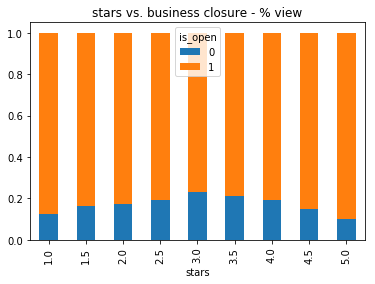

In [98]:
df_plot = catData.groupby(['is_open', 'stars']).size().reset_index().pivot(columns='is_open', index='stars', values=0)
df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
df_plot=df_plot.iloc[:,0:2]
df_plot.plot(kind='bar', stacked=True)
plt.title("stars vs. business closure - % view")

Absoluate Barplot of stars vs closure for Food places in Toronto
Absoluate Barplot of stars vs closure for Food places in Tempe
Absoluate Barplot of stars vs closure for Food places in Scottsdale


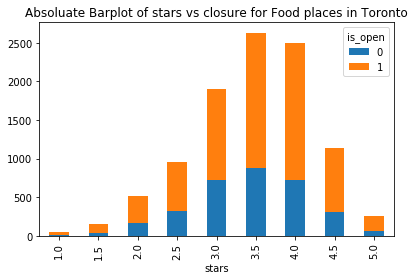

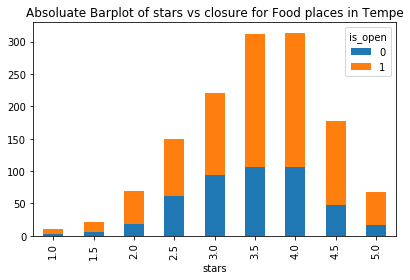

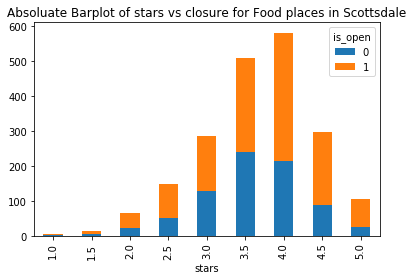

In [80]:
# pick out the 3 potential cities to look
l=["Toronto",'Tempe','Scottsdale'] # potential cities
#l=catData.city.value_counts().index

for i in range(0,len(l)): #len(l)
    file_title='Absoluate Barplot of stars vs closure for Food places in ' + l[i]
    print(file_title)
    #fig, axis = plt.subplots()
    df_plot = catFood[catFood['city']==l[i]].groupby(['is_open', 'stars']).size().reset_index().pivot(columns='is_open', index='stars', values=0)
    
    #df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
    #df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
    #df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
    #df_plot=df_plot.iloc[:,0:2]
    
    df_plot.plot(kind='bar', stacked=True)
    plt.title(file_title)
    plt.tight_layout()
    plt.savefig(file_title + '.pdf', 
                    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                    orientation='portrait', papertype=None, format=None, 
                    transparent=True, pad_inches=0.25, frameon=None)  
    





Barplot of stars vs closure for Food places inToronto
Barplot of stars vs closure for Food places inTempe
Barplot of stars vs closure for Food places inScottsdale
Barplot of Stars vs closure for NonFood places inToronto
Barplot of Stars vs closure for NonFood places inTempe
Barplot of Stars vs closure for NonFood places inScottsdale


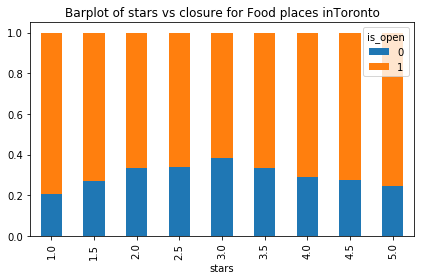

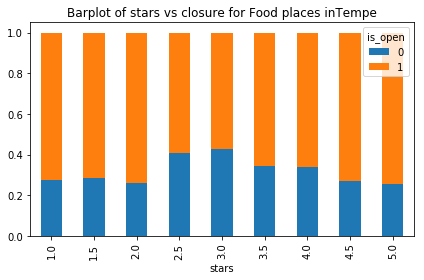

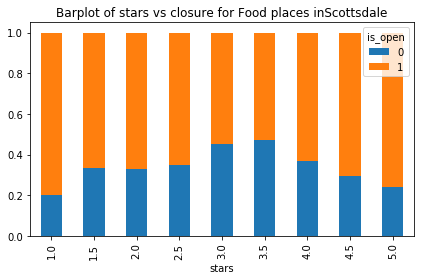

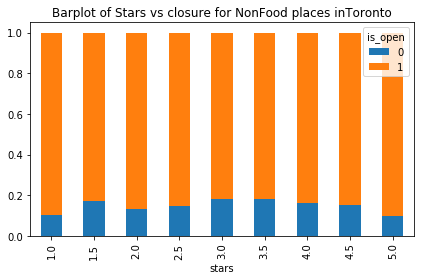

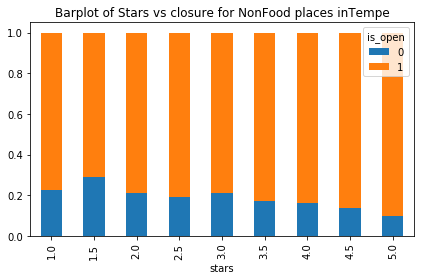

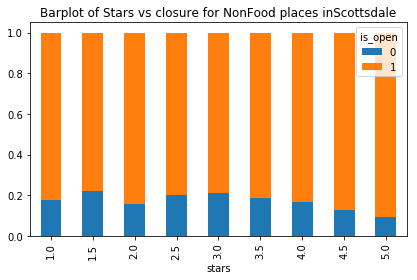

In [78]:
# pick out the 3 potential cities to look
l=["Toronto",'Tempe','Scottsdale'] # potential cities
#l=catData.city.value_counts().index

for i in range(0,len(l)): #len(l)
    file_title='Barplot of stars vs closure for Food places in' + l[i]
    print(file_title)
    #fig, axis = plt.subplots()
    df_plot = catFood[catFood['city']==l[i]].groupby(['is_open', 'stars']).size().reset_index().pivot(columns='is_open', index='stars', values=0)
    df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
    df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
    df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
    df_plot=df_plot.iloc[:,0:2]
    df_plot.plot(kind='bar', stacked=True)
    plt.title(file_title)
    plt.tight_layout()
    plt.savefig(file_title + '.pdf', 
                    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                    orientation='portrait', papertype=None, format=None, 
                    transparent=True, pad_inches=0.25, frameon=None)  
    
    
for i in range(0,len(l)): #len(l)
    file_title='Barplot of Stars vs closure for NonFood places in' + l[i]
    print(file_title)
    #fig, axis = plt.subplots()
    df_plot = catNonFood[catNonFood['city']==l[i]].groupby(['is_open', 'stars']).size().reset_index().pivot(columns='is_open', index='stars', values=0)
    df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
    df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
    df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
    df_plot=df_plot.iloc[:,0:2]
    df_plot.plot(kind='bar', stacked=True)
    plt.title(file_title)
    plt.tight_layout()
    plt.savefig(file_title + '.pdf', 
                    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                    orientation='portrait', papertype=None, format=None, 
                    transparent=True, pad_inches=0.25, frameon=None)      

Absoluate Barplot of tip vs closure for Food places inToronto
Absoluate Barplot of tip vs closure for Food places inTempe
Absoluate Barplot of tip vs closure for Food places inScottsdale


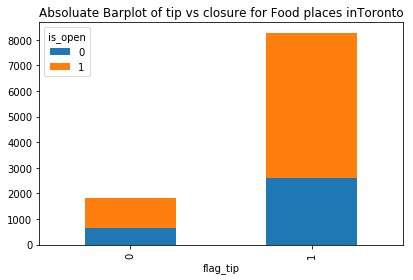

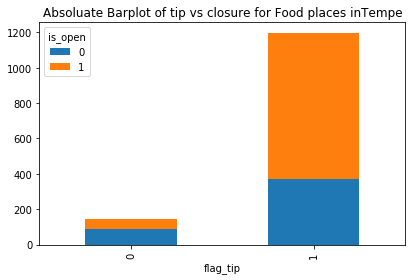

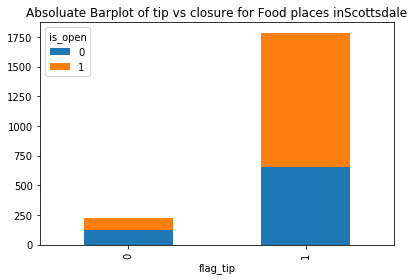

In [99]:
l=["Toronto",'Tempe','Scottsdale'] # potential cities
#l=catData.city.value_counts().index

for i in range(0,len(l)): #len(l)
    file_title='Absoluate Barplot of tip vs closure for Food places in' + l[i]
    print(file_title)
    #fig, axis = plt.subplots()
    df_plot = catFood[catFood['city']==l[i]].groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
    #df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
    #df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
    #df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
    #df_plot=df_plot.iloc[:,0:2]
    df_plot.plot(kind='bar', stacked=True)
    plt.title(file_title)
    plt.tight_layout()
    plt.savefig(file_title + '.pdf', 
                    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                    orientation='portrait', papertype=None, format=None, 
                    transparent=True, pad_inches=0.25, frameon=None)  

Barplot of tip vs closure for Food places inToronto
Barplot of tip vs closure for Food places inTempe
Barplot of tip vs closure for Food places inScottsdale
Barplot of tip vs closure for NonFood places inToronto
Barplot of tip vs closure for NonFood places inTempe
Barplot of tip vs closure for NonFood places inScottsdale


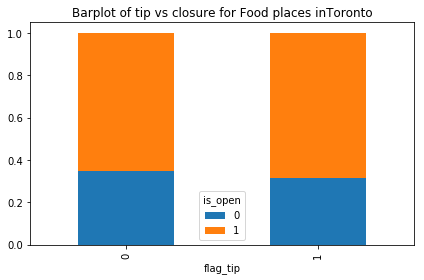

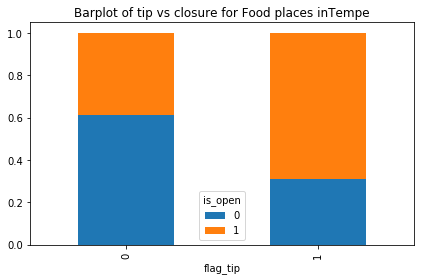

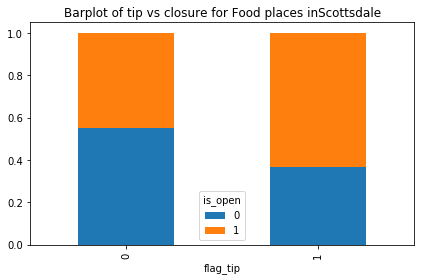

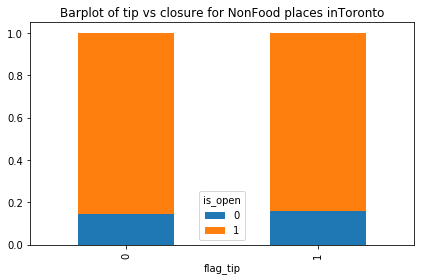

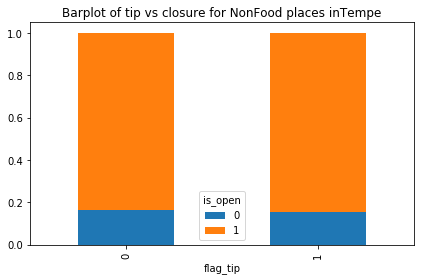

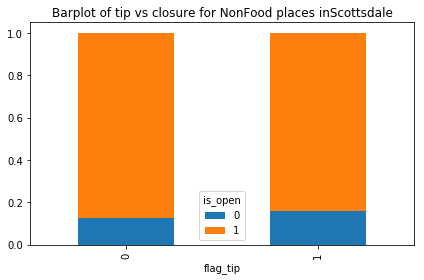

In [34]:
l=["Toronto",'Tempe','Scottsdale'] # potential cities
#l=catData.city.value_counts().index

for i in range(0,len(l)): #len(l)
    file_title='Barplot of tip vs closure for Food places in' + l[i]
    print(file_title)
    #fig, axis = plt.subplots()
    df_plot = catFood[catFood['city']==l[i]].groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
    df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
    df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
    df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
    df_plot=df_plot.iloc[:,0:2]
    df_plot.plot(kind='bar', stacked=True)
    plt.title(file_title)
    plt.tight_layout()
    plt.savefig(file_title + '.pdf', 
                    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                    orientation='portrait', papertype=None, format=None, 
                    transparent=True, pad_inches=0.25, frameon=None)  
    
    
for i in range(0,len(l)): #len(l)
    file_title='Barplot of tip vs closure for NonFood places in' + l[i]
    print(file_title)
    #fig, axis = plt.subplots()
    df_plot = catNonFood[catNonFood['city']==l[i]].groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
    df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
    df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
    df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
    df_plot=df_plot.iloc[:,0:2]
    df_plot.plot(kind='bar', stacked=True)
    plt.title(file_title)
    plt.tight_layout()
    plt.savefig(file_title + '.pdf', 
                    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                    orientation='portrait', papertype=None, format=None, 
                    transparent=True, pad_inches=0.25, frameon=None)      

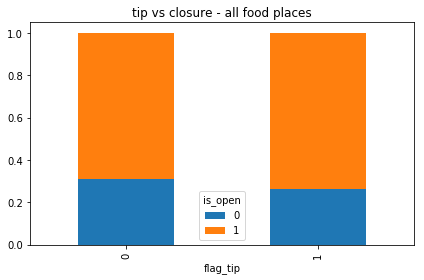

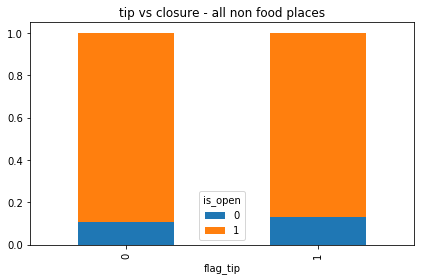

In [35]:
####
# how is it look like for flag_tips for all food and all non food, ie combine all city
####
df_plot = catData[catData['cat']==1].groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
df_plot=df_plot.iloc[:,0:2]
df_plot.plot(kind='bar', stacked=True)
plt.title("tip vs closure - all food places")
plt.tight_layout()

df_plot = catData[catData['cat']==0].groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
df_plot=df_plot.iloc[:,0:2]
df_plot.plot(kind='bar', stacked=True)
plt.title("tip vs closure - all non food places")
plt.tight_layout()


In [287]:
#Continues variable
contData =business.drop(["business_id", 'name',"city",'state','categories'], axis=1)
# re-arrange order
contData=contData.iloc[:,[0,1,4,3,2]]

contData.head(2)

,stars,review_count,flag_tip_sum,cat,is_open
0,3.0,5,1.0,0,0
1,2.5,128,22.0,1,1


In [288]:
contFood=contData[contData['cat']==1]

In [289]:
# check for outliers
statdata2 = contFood.describe().transpose()

#Outliers are:
#Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
#iqr_df = df_full_data.quantile([.25,.75]).transpose()
#iqr = q3 - q1
#lower_bound = q1 -(1.5 * iqr) 
#upper_bound = q3 +(1.5 * iqr) 

statdata2.rename(columns={'25%': 'q1', '50%':'q2', '75%':'q3'}, inplace=True)

statdata2['lower_bound'] = statdata2.apply(lambda row: row.q1 -(1.5 * (row.q3 - row.q1)), axis=1)
statdata2['upper_bound'] = statdata2.apply(lambda row: row.q3 +(1.5 * (row.q3 - row.q1)), axis=1)

statdata2

,count,mean,std,min,q1,q2,q3,max,lower_bound,upper_bound
stars,74587.0,3.482959,0.825822,1.0,3.0,3.5,4.0,5.0,1.5,5.5
review_count,74587.0,59.418129,160.215276,3.0,6.0,17.0,52.0,8348.0,-63.0,121.0
flag_tip_sum,74587.0,12.212651,35.126093,0.0,1.0,3.0,10.0,1503.0,-12.5,23.5
cat,74587.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
is_open,74587.0,0.730141,0.443890,0.0,0.0,1.0,1.0,1.0,-1.5,2.5


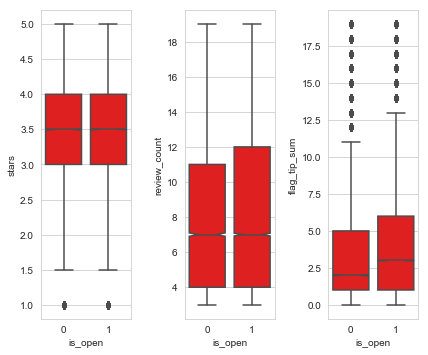

In [290]:
# plot box plot for continue variables
l= contData.columns.values

numColumns=5
numRows = len(l)-1/numColumns
lim=20

plt.figure(figsize=(numColumns*2,5*numRows))

for i in range(0,len(l)-2): #
    plt.subplot(numRows + 1,numColumns,i+1)
    sns.set_style('whitegrid')
    #y=contData[l[i]]
    if i == 0:
        sns.boxplot(x=contFood.is_open, y=contFood[l[i]], color='red',orient='v', notch=True)
    else:
        x=contFood[contFood[l[i]]<lim]
        sns.boxplot(x=x.is_open, y=x[l[i]], color='red',orient='v', notch=True)
    
    plt.tight_layout()
plt.savefig("BoxPlots_ContinuousVarBy_isOpen_FoodPlaces_exclude_above20reviews20tips")
# Comments: number of tips received can be a good predictor for food places closure


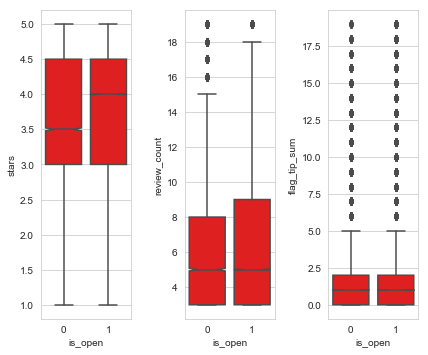

In [291]:
contNonFood=contData[contData['cat']==0]

numColumns=5
numRows = len(l)-1/numColumns
lim=20

plt.figure(figsize=(numColumns*2,5*numRows))

for i in range(0,len(l)-2): #
    plt.subplot(numRows + 1,numColumns,i+1)
    sns.set_style('whitegrid')
    #y=contData[l[i]]
    if i == 0:
        sns.boxplot(x=contNonFood.is_open, y=contNonFood[l[i]], color='red',orient='v', notch=True)
    else:
        x=contNonFood[contNonFood[l[i]]<lim]
        sns.boxplot(x=x.is_open, y=x[l[i]], color='red',orient='v', notch=True) #color='royalblue'
        
    plt.tight_layout()
plt.savefig("BoxPlots_ContinuousVarBy_isOpen_Non_FoodPlaces_exclude_above20reviews20tips")

In [ ]:
# SO far predictive variable: stars, review_count, flag_tip_sum, flag_tip, maybe add in sentiment
# let's pickle this business_tip data

## Business merge with sentiment score - Tempe

In [40]:
# load in pickled file business with tips var in
filename = 'business_tip'
infile = open(filename,'rb')
business_tip= pickle.load(infile)
infile.close()
print(business.shape)
print(business_tip.shape)
business_tip.head(2)

# select only Tempe food as sentiment only done on tempe food business
business_tempe=business_tip[business_tip['city']=='Tempe']  
business_tempe=business_tempe[business_tempe['cat']==1]

business_tempe=business_tempe[['business_id','city','stars','review_count','cat','flag_tip_sum','flag_tip','is_open']]
print(business_tempe.shape) #there are 1342 food business in tempe
business_tempe.head(2) #(1342, 6) for Tempe food

(192127, 11)
(192127, 11)
(1342, 8)


,business_id,city,stars,review_count,cat,flag_tip_sum,flag_tip,is_open
318,sohYJdSBaNhTPPqOOFc9QA,Tempe,5.0,3,1,0.0,0,1
339,8TBt9XAVZIZR2Y0EqBHskg,Tempe,2.5,147,1,10.0,1,1


In [41]:
# load pickled sentiment file back in and check data validity 
filename = 'Sentiment_Tempe_Food_by_Bus'
infile = open(filename,'rb')
Sentiment_Tempe= pickle.load(infile)
infile.close()
Sentiment_Tempe.head(2)

,business_id,sentiment_mean,polarity_mean,sentiment_type_sum
0,-0Sgh0QlUKVsWosCWJzGqQ,0.035416,0.537515,4
1,-2A9emZwBK8zYHPnAmM0hw,0.036158,0.432403,0


In [42]:
business_tempe=pd.merge(business_tempe, Sentiment_Tempe,on='business_id',how='left')
print(business_tempe.shape)
business_tempe.head(2)  #(1342, 11)

(1342, 11)


,business_id,city,stars,review_count,cat,flag_tip_sum,flag_tip,is_open,sentiment_mean,polarity_mean,sentiment_type_sum
0,sohYJdSBaNhTPPqOOFc9QA,Tempe,5.0,3,1,0.0,0,1,0.274500,0.600695,3
1,8TBt9XAVZIZR2Y0EqBHskg,Tempe,2.5,147,1,10.0,1,1,0.153625,0.519694,70


In [43]:
business_tempe.isnull().sum() # no na being created, ie. each business in Tempe has received some review that generate sentiment score

business_id           0
city                  0
stars                 0
review_count          0
cat                   0
flag_tip_sum          0
flag_tip              0
is_open               0
sentiment_mean        0
polarity_mean         0
sentiment_type_sum    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E52EA8B550>,
      dtype=object)

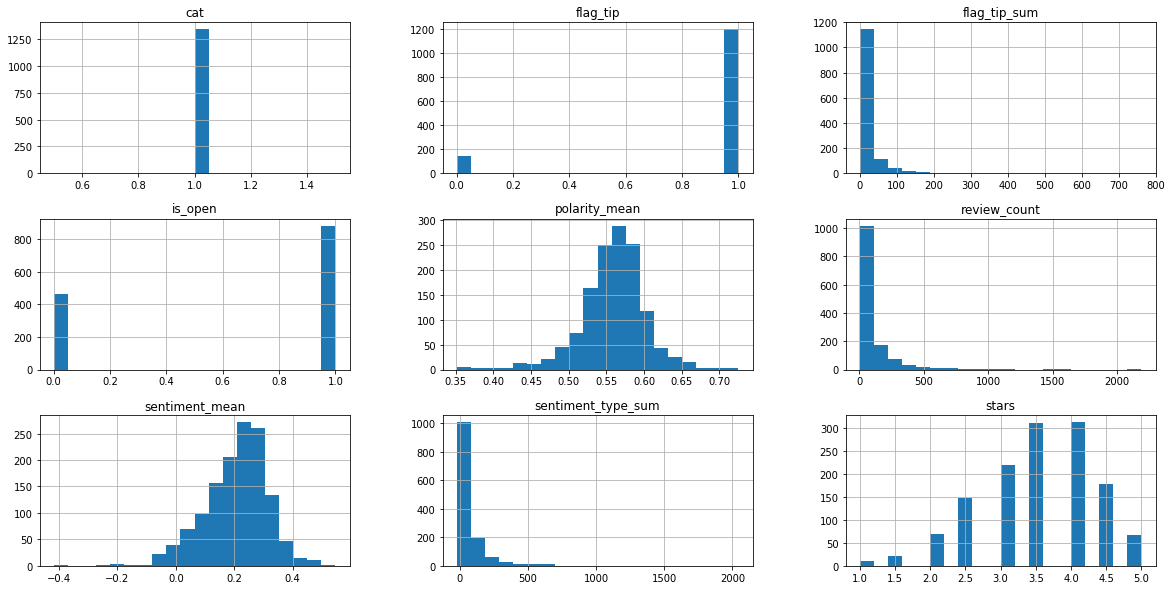

In [44]:
# overall distribution of data fields
business_tempe.hist(bins=20,figsize=(20,10)) #figsize=(20,15)

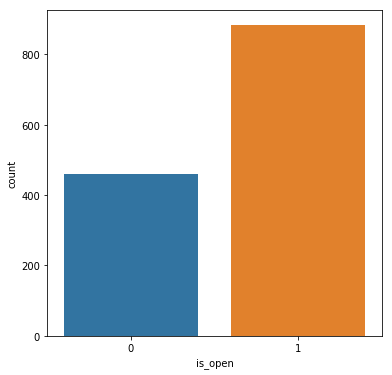

In [45]:
# check target variable distribution
plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=business_tempe);

### Look at continuous and categorical var separately

In [46]:
business_tempe.head(2)

,business_id,city,stars,review_count,cat,flag_tip_sum,flag_tip,is_open,sentiment_mean,polarity_mean,sentiment_type_sum
0,sohYJdSBaNhTPPqOOFc9QA,Tempe,5.0,3,1,0.0,0,1,0.274500,0.600695,3
1,8TBt9XAVZIZR2Y0EqBHskg,Tempe,2.5,147,1,10.0,1,1,0.153625,0.519694,70


Categorical Variables

In [47]:
#catData['flag_tip']=catData['flag_tip_sum'].apply(lambda x : 0 if x==0 else 1)
catData=business_tempe.drop(["business_id", "cat","city","review_count","flag_tip_sum","sentiment_mean","polarity_mean","sentiment_type_sum"], axis=1)

catData.head(2)

,stars,flag_tip,is_open
0,5.0,0,1
1,2.5,1,1


Text(0.5, 0, 'stars ')

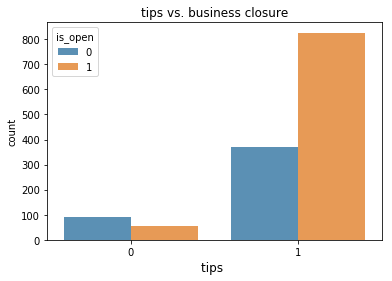

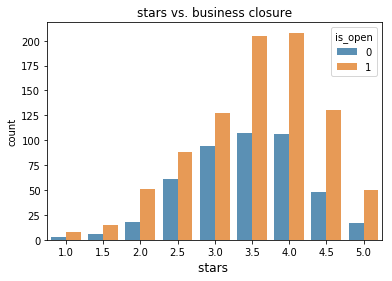

In [215]:
import dexplot as dxp
#dxp.aggplot(agg='state', data=catData, hue='is_open')

plt.figure(figsize=(6,4))
ax=sns.countplot(x='flag_tip',data=catData,hue="is_open",alpha=0.8 );
plt.title("tips vs. business closure")
plt.xlabel('tips ', fontsize=12)

plt.figure(figsize=(6,4))
ax=sns.countplot(x='stars',data=catData,hue="is_open",alpha=0.8 );
plt.title("stars vs. business closure")
plt.xlabel('stars ', fontsize=12)

Text(0.5, 1.0, 'stars vs. business closure')

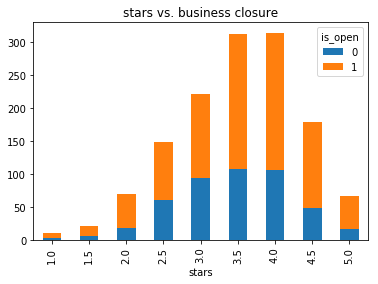

In [49]:
df_plot = catData.groupby(['is_open', 'stars']).size().reset_index().pivot(columns='is_open', index='stars', values=0)
df_plot.plot(kind='bar', stacked=True)
plt.title("stars vs. business closure")

Text(0.5, 1.0, 'stars vs. business closure - % view')

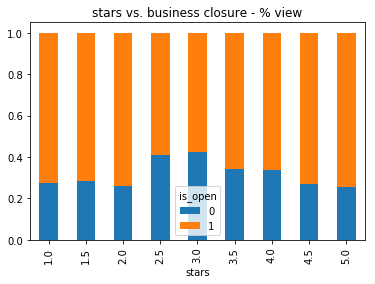

In [50]:
df_plot = catData.groupby(['is_open', 'stars']).size().reset_index().pivot(columns='is_open', index='stars', values=0)
df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
df_plot=df_plot.iloc[:,0:2]
df_plot.plot(kind='bar', stacked=True)
plt.title("stars vs. business closure - % view")

Text(0.5, 1.0, 'tip vs. business closure')

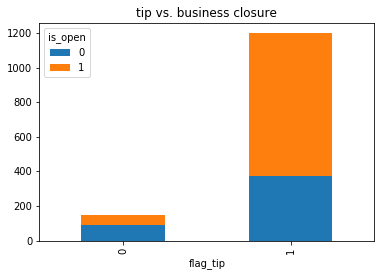

In [51]:
df_plot = catData.groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
df_plot.plot(kind='bar', stacked=True)
plt.title("tip vs. business closure")

Text(0.5, 1.0, 'tip vs. business closure - % view')

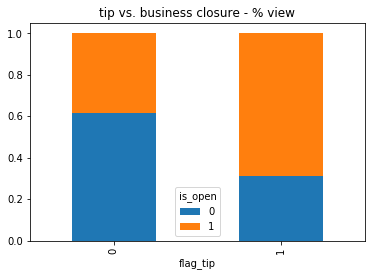

In [52]:
df_plot = catData.groupby(['is_open', 'flag_tip']).size().reset_index().pivot(columns='is_open', index='flag_tip', values=0)
df_plot['total']=df_plot.iloc[:,0]+df_plot.iloc[:,1]
df_plot.iloc[:,0]=df_plot.iloc[:,0]/df_plot.total
df_plot.iloc[:,1]=df_plot.iloc[:,1]/df_plot.total
df_plot=df_plot.iloc[:,0:2]
df_plot.plot(kind='bar', stacked=True)

plt.title("tip vs. business closure - % view")
## comments: receive any tip or not seems to be important variable. 
# This is different from aggreate look where whether receive a tip or not does not matter for business closure

Continuse variables

In [66]:
# separat continuse variable 
contData =business_tempe.drop(["business_id", "city", "stars",'cat','flag_tip'], axis=1)
contData.head(2)

,review_count,flag_tip_sum,is_open,sentiment_mean,polarity_mean,sentiment_type_sum
0,3,0.0,1,0.274500,0.600695,3
1,147,10.0,1,0.153625,0.519694,70


In [67]:
# re-arrange oder
contData=contData.iloc[:,[0,1,3,4,5,2]]

contData.head(2)

,review_count,flag_tip_sum,sentiment_mean,polarity_mean,sentiment_type_sum,is_open
0,3,0.0,0.274500,0.600695,3,1
1,147,10.0,0.153625,0.519694,70,1


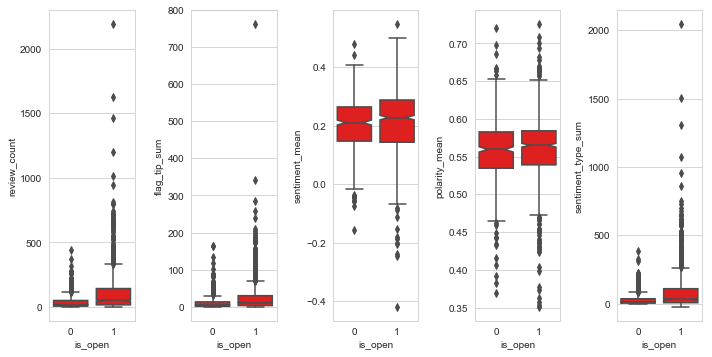

In [284]:
# plot box plot for continue variables
l= contData.columns.values
numColumns=5
numRows = len(l)-1/numColumns

plt.figure(figsize=(numColumns*2,5*numRows))
for i in range(0,len(l)-1):
    plt.subplot(numRows + 1,numColumns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x=contData.is_open, y=contData[l[i]], color='red',orient='v', notch=True)
    plt.tight_layout()
plt.savefig('BoxPlots_ContinuousVarBy_isOpen_TempeFood')
# Comments: too many outliers, need to cut review number by 2000, tip number by 1000

In [ ]:
# there is too much outliers in review counts, need to cut it to below 500; tip sum below 100,
# need to cut at 500 for sneimate type sum --> should do a pivot to show how many sentiment_type_sum >0, =0, <0
# mean sentiment shows mild differece in median

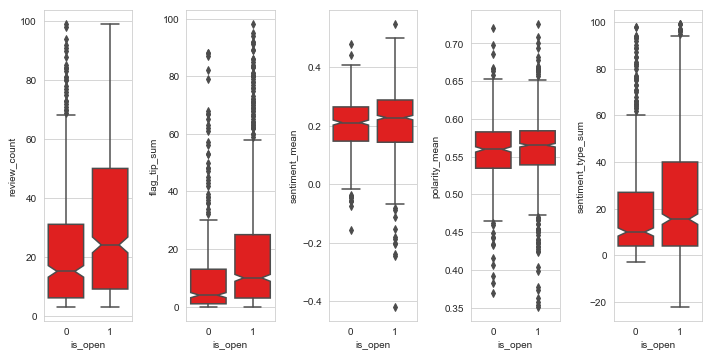

In [283]:
l= contData.columns.values
numColumns=5
numRows = len(l)-1/numColumns
lim=100
lim2=100

plt.figure(figsize=(numColumns*2,5*numRows))
for i in range(0,len(l)-1): #
    plt.subplot(numRows + 1,numColumns,i+1)
    sns.set_style('whitegrid')
    #y=contData[l[i]]
    if i == 2|3:
        sns.boxplot(x=contData.is_open, y=contData[l[i]], color='red',orient='v', notch=True)
    elif i==0|1:
        x=contData[contData[l[i]]<lim]
        sns.boxplot(x=x.is_open, y=x[l[i]], color='red',orient='v', notch=True)
    else:
        x=contData[contData[l[i]]<lim2]
        sns.boxplot(x=x.is_open, y=x[l[i]], color='red',orient='v', notch=True)
        
    
    plt.tight_layout()
plt.savefig("BoxPlots_ContinuousVarBy_isOpen_TempeFood_curveout_outliersabove20")
# Comments: key variables identified: review_count, flag_tip_sum, sentiment type sum. Sentiment and polarity may have mild effect

In [87]:
# check for outliers
statdata = contData.describe().transpose()

#Outliers are:
#Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
#iqr_df = df_full_data.quantile([.25,.75]).transpose()
#iqr = q3 - q1
#lower_bound = q1 -(1.5 * iqr) 
#upper_bound = q3 +(1.5 * iqr) 

statdata.rename(columns={'25%': 'q1', '50%':'q2', '75%':'q3'}, inplace=True)

statdata['lower_bound'] = statdata.apply(lambda row: row.q1 -(1.5 * (row.q3 - row.q1)), axis=1)
statdata['upper_bound'] = statdata.apply(lambda row: row.q3 +(1.5 * (row.q3 - row.q1)), axis=1)

statdata

,count,mean,std,min,q1,q2,q3,max,lower_bound,upper_bound
review_count,1342.0,93.000000,158.568291,3.000000,11.000000,35.50000,109.000000,2189.000000,-136.000000,256.000000
flag_tip_sum,1342.0,21.095380,39.556318,0.000000,2.000000,8.00000,23.000000,762.000000,-29.500000,54.500000
sentiment_mean,1342.0,0.207006,0.108274,-0.418296,0.146060,0.22156,0.275895,0.546592,-0.048694,0.470649
polarity_mean,1342.0,0.559210,0.044133,0.351160,0.537828,0.56304,0.583918,0.725450,0.468693,0.653053
sentiment_type_sum,1342.0,71.960507,139.681861,-22.000000,6.000000,22.00000,80.750000,2045.000000,-106.125000,192.875000
is_open,1342.0,0.657228,0.474813,0.000000,0.000000,1.00000,1.000000,1.000000,-1.500000,2.500000


In [93]:
## Taking out outliers
df=business_tempe[business_tempe['review_count']<=250]
df.shape[0]/business_tempe.shape[0]
#print((contData[contData['review_count']<300].shape[0])/contData.shape[0])

0.9068554396423248

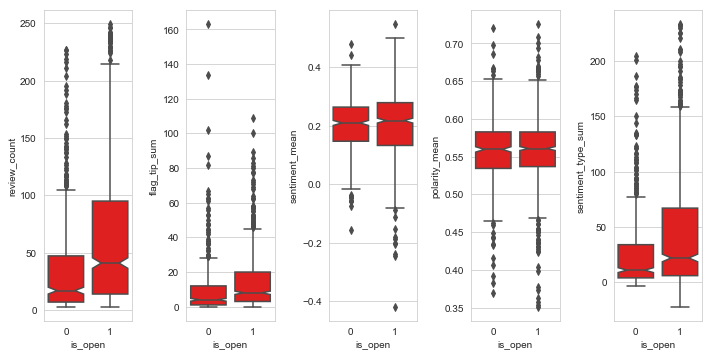

In [292]:
# drop outliers
contData2 =df.drop(["business_id", "city", "stars",'cat','flag_tip'], axis=1)
contData2=contData2.iloc[:,[0,1,3,4,5,2]]


# plot box plot for continue variables
l= contData2.columns.values
numColumns=5
numRows = len(l)-1/numColumns

plt.figure(figsize=(numColumns*2,5*numRows))
for i in range(0,len(l)-1):
    plt.subplot(numRows + 1,numColumns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x=contData2.is_open, y=contData2[l[i]], color='red',orient='v', notch=True)
    plt.tight_layout()
plt.savefig('BoxPlots_ContinuousVarBy_isOpen_TempeFood_dropoutliers')
# Comments: seem only polarity doesn't have much predictive power

In [95]:
df.head()

,business_id,city,stars,review_count,cat,flag_tip_sum,flag_tip,is_open,sentiment_mean,polarity_mean,sentiment_type_sum
0,sohYJdSBaNhTPPqOOFc9QA,Tempe,5.0,3,1,0.0,0,1,0.274500,0.600695,3
1,8TBt9XAVZIZR2Y0EqBHskg,Tempe,2.5,147,1,10.0,1,1,0.153625,0.519694,70
2,M9N2eaO8PkT7MHGLLA6V3Q,Tempe,2.0,3,1,2.0,1,0,-0.036128,0.556085,-1
3,aXsmmtepl0JZNcl3pkXqww,Tempe,4.0,100,1,27.0,1,1,0.257540,0.576532,85
4,HxUD_4GpOInD-mXIppZiZA,Tempe,5.0,23,1,2.0,1,1,0.311257,0.480825,24


In [101]:
# re-arrange oder
df['is_closed'] =df['is_open'].apply(lambda x : 1 if x==0 else 0)
df2=df.iloc[:,[2,3,5,6,8,9,10,11]]
df2.head()

C:\Users\JayZ2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,stars,review_count,flag_tip_sum,flag_tip,sentiment_mean,polarity_mean,sentiment_type_sum,is_closed
0,5.0,3,0.0,0,0.274500,0.600695,3,0
1,2.5,147,10.0,1,0.153625,0.519694,70,0
2,2.0,3,2.0,1,-0.036128,0.556085,-1,1
3,4.0,100,27.0,1,0.257540,0.576532,85,0
4,5.0,23,2.0,1,0.311257,0.480825,24,0


In [102]:
df2.groupby("is_closed").mean() 

,stars,review_count,flag_tip_sum,flag_tip,sentiment_mean,polarity_mean,sentiment_type_sum
is_closed,,,,,,,
0,3.492157,63.430065,14.091503,0.926797,0.201719,0.557886,44.756863
1,3.433628,37.632743,10.263274,0.803097,0.199616,0.556964,27.995575


In [108]:
### correlation matrix ###
corr_df2=df2.loc[:,"stars":"is_closed"]
corr_matrix=corr_df2.corr()
corr_matrix['is_closed'].sort_values(ascending=False)

is_closed             1.000000
sentiment_mean       -0.009202
polarity_mean        -0.009788
stars                -0.033372
flag_tip_sum         -0.111908
sentiment_type_sum   -0.168461
flag_tip             -0.184497
review_count         -0.210123
Name: is_closed, dtype: float64

In [109]:
# define a function for corr heatmap  - it is better than corrl matrix #
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

<Figure size 432x288 with 0 Axes>

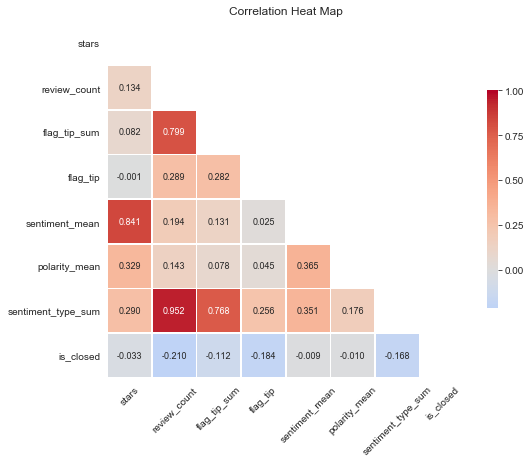

In [110]:
corr_chart(df_corr =df2) 
# comment: tip and stars highly correlated for Tempe food places. Interesting that sentiment type sum is highly correlated with
# review_count

In [114]:
df2.head()

,stars,review_count,flag_tip_sum,flag_tip,sentiment_mean,polarity_mean,sentiment_type_sum,is_closed
0,5.0,3,0.0,0,0.274500,0.600695,3,0
1,2.5,147,10.0,1,0.153625,0.519694,70,0
2,2.0,3,2.0,1,-0.036128,0.556085,-1,1
3,4.0,100,27.0,1,0.257540,0.576532,85,0
4,5.0,23,2.0,1,0.311257,0.480825,24,0


### Part 3 - Prep Data for Part 4 Feature Selection and Part 5 Modeling

In [269]:
X = df2.drop('is_closed', axis=1)
y = df2['is_closed'].as_matrix()

#y.is_closed.unique() #1
print("closure rate for full dataset is:", sum(y)/len(y)) # 37% closure on data)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=RANDOM_SEED, stratify=y)


print("closure rate for train dataset is:", sum(y_train)/len(y_train)) # 37% closure on train
print("closure rate for test dataset is:", sum(y_test)/len(y_test)) # 37% closure on test


# Normalize the training data
sc = StandardScaler()
# Fit the scaler to the training data
X_train_s = sc.fit_transform(X_train)
# Then standardise both training and test sets with that scaler
X_test_s = sc.transform (X_test)


closure rate for full dataset is: 0.37140509449465897
closure rate for train dataset is: 0.3713733075435203
closure rate for test dataset is: 0.37158469945355194


C:\Users\JayZ2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\JayZ2\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [246]:
print(X_train.shape)
print(X_train_s.shape)
X_train.head()

(1034, 7)
(1034, 7)


,stars,review_count,flag_tip_sum,flag_tip,sentiment_mean,polarity_mean,sentiment_type_sum
945,4.0,27,3.0,1,0.329358,0.569932,25
278,2.5,10,0.0,0,0.034187,0.454765,4
10,3.0,73,42.0,1,0.139622,0.532852,24
798,4.0,39,19.0,1,0.254428,0.573117,34
556,4.0,69,11.0,1,0.283657,0.572910,59


In [270]:
X_train_s

array([[ 0.604, -0.468, -0.596, ...,  1.151,  0.266, -0.299],
       [-1.154, -0.749, -0.779, ..., -1.527, -2.32 , -0.726],
       [-0.568,  0.294,  1.78 , ..., -0.57 , -0.567, -0.32 ],
       ...,
       [-1.154, -0.65 , -0.475, ..., -1.311,  0.669, -0.726],
       [-0.568, -0.766, -0.779, ...,  0.399, -1.382, -0.625],
       [ 1.19 ,  0.012,  0.135, ...,  0.33 , -0.194,  0.29 ]])

In [ ]:
#np.array(df2['stars'])

### Part 4 Feature Importancy Analysis and Selection

In [278]:
#1) Feature Selection using DecisionTreeClassier()
#Source: https://www.kaggle.com/hjlee0421/predicting-employee-kernelover

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X,y)

In [1]:
## plot the importances ##
importances = dtree.feature_importances_
feat_names = df2.drop(['is_closed'],axis=1).columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='red',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation=45,fontsize=14) # rotation='vertical'
plt.xlim([-1, len(indices)])
plt.show()
plt.savefig('DecisionTreeFeaturesImportance')

NameError: name 'dtree' is not defined

In [280]:
#2) Feature Selection using Recursive Feature Elimination (RFE) 
from sklearn.feature_selection import RFE
model = LogisticRegression()

rfe = RFE(model, 5) #Number of Features Selected
rfe = rfe.fit(X,y)

print("Num Features: %s" % (rfe.n_features_))
print("Selected Features: %s" % (rfe.support_))
print("Feature Ranking: %s" % (rfe.ranking_))

sf = rfe.support_
fr = rfe.ranking_
featureNames = list(X.columns.values) 

#Create empty dataframe
RFE_df = pd.DataFrame()
#Add sf, fr and featureNames to the dataframe
RFE_df = pd.DataFrame(sf, fr)
RFE_df['featureNames'] = featureNames

RFE_df 

Num Features: 5
Selected Features: [ True  True False  True  True  True False]
Feature Ranking: [1 1 3 1 1 1 2]


C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0,featureNames
1,True,stars
1,True,review_count
3,False,flag_tip_sum
1,True,flag_tip
1,True,sentiment_mean
1,True,polarity_mean
2,False,sentiment_type_sum


Best alpha using built-in LassoCV: 0.006023
Best score using built-in LassoCV: 0.082149
stars                -0.031404
review_count         -0.005479
flag_tip_sum          0.004486
flag_tip             -0.143119
sentiment_mean        0.000000
polarity_mean         0.000000
sentiment_type_sum    0.003963
dtype: float64
Lasso picked 5 variables and eliminated the other 2 variables


C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

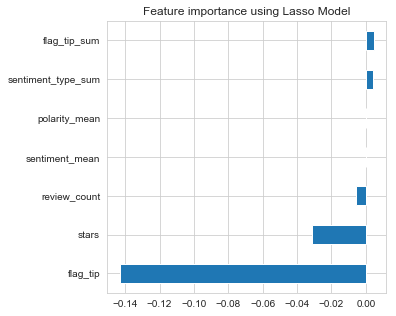

In [281]:
#3) Feature Selection using Embedded method
#Source: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print(coef)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
plt.figure(figsize=(5,5))
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Part 5 modeling building

In [230]:
## get model data ready
## gather three explanatory variables and response into a numpy array 
## here we use .T to obtain the transpose for the structure we want
#model_data = np.array([np.array(df2['stars']), np.array(df2['review_count']), np.array(df2['flag_tip_sum']), np.array(df2['flag_tip']),
#    
#                       np.array(df2['sentiment_mean']),np.array(df2['polarity_mean']),np.array(df2['sentiment_type_sum']),
#                       np.array(df2['is_closed'])]).T
#print(model_data.shape) # full data is (1217,8)

##### Scale / Standardize data

In [267]:
np.array(X_train_s)

array([[ 0.604, -0.468, -0.596, ...,  1.151,  0.266, -0.299],
       [-1.154, -0.749, -0.779, ..., -1.527, -2.32 , -0.726],
       [-0.568,  0.294,  1.78 , ..., -0.57 , -0.567, -0.32 ],
       ...,
       [-1.154, -0.65 , -0.475, ..., -1.311,  0.669, -0.726],
       [-0.568, -0.766, -0.779, ...,  0.399, -1.382, -0.625],
       [ 1.19 ,  0.012,  0.135, ...,  0.33 , -0.194,  0.29 ]])

In [274]:
sc.fit_transform(X_train)

C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.604, -0.468, -0.596, ...,  1.151,  0.266, -0.299],
       [-1.154, -0.749, -0.779, ..., -1.527, -2.32 , -0.726],
       [-0.568,  0.294,  1.78 , ..., -0.57 , -0.567, -0.32 ],
       ...,
       [-1.154, -0.65 , -0.475, ..., -1.311,  0.669, -0.726],
       [-0.568, -0.766, -0.779, ...,  0.399, -1.382, -0.625],
       [ 1.19 ,  0.012,  0.135, ...,  0.33 , -0.194,  0.29 ]])

In [275]:
### Q how to combine arrarys? to combine X_train_s and y_train
#model_data=np.array([np.array(X_train_s),y_train])
#model_data


In [247]:
#sc.fit_transform(np.array(X_train['stars']))

In [276]:
# if using X_train before
model_data = np.array([np.array(X_train['stars']), np.array(X_train['review_count']), np.array(X_train['flag_tip_sum']), 
                       np.array(X_train['flag_tip']),np.array(X_train['sentiment_mean']),
                       np.array(X_train['polarity_mean']),np.array(X_train['sentiment_type_sum']),
                       y_train]).T
    
print(model_data.shape)   # train set is (1034, 8)                   

(1034, 8)


In [277]:
model_data[0:2]

array([[ 4.   , 27.   ,  3.   ,  1.   ,  0.329,  0.57 , 25.   ,  1.   ],
       [ 2.5  , 10.   ,  0.   ,  0.   ,  0.034,  0.455,  4.   ,  0.   ]])

In [213]:
## it seems different variable selection return different key variables: based on tree and lasso, important var:
# review_count, flg_tip, stars, sentiment mean, polarity mean
# can drop var: fag_tip_sum, sentiment_type_sum

#### Quick Fit model and Evaluating model using KFold cross-validation design

In [214]:
# specify the set of classifiers being evaluated
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
names = ["Naive_Bayes", "Logistic_Regression","Logistic_with_regularity","XGB_Classifier"]
names

['Naive_Bayes',
 'Logistic_Regression',
 'Logistic_with_regularity',
 'XGB_Classifier']

In [215]:
#from nltk.classify.scikitlearn import SklearnClassifier
#from sklearn.svm import LinearSVC, SVC

#LinearSVC_classifier = SklearnClassifier(SVC(kernel='linear',probability=True))

In [216]:
### Benchmark models: bernouli
classifiers = [BernoulliNB(alpha=1.0, binarize=0.5, 
                           class_prior = [0.5, 0.5], fit_prior=False), 
               LogisticRegression(),LogisticRegression(C=100),XGBClassifier()]  #high C means less regularity means possible overfit
classifiers

[BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=100, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=1, seed=

In [217]:
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

# ten-fold cross-validation employed here
N_FOLDS = 10
# set up numpy array for storing results
cv_results_roc = np.zeros((N_FOLDS, len(names)))
cv_results_recall=np.zeros((N_FOLDS, len(names)))

In [218]:
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict_proba = clf.predict_proba(X_test)
        y_test_predict = clf.predict(X_test)
        
        fold_method_result_roc = roc_auc_score(y_test, y_test_predict_proba[:,1])
        fold_method_result_recall = recall_score(y_test, y_test_predict) 
        
        print('Area under ROC curve:', fold_method_result_roc)
        print('Area under Recall:', fold_method_result_recall)
        
        cv_results_roc[index_for_fold, index_for_method] = fold_method_result_roc
        cv_results_recall[index_for_fold, index_for_method] = fold_method_result_recall
        
        index_for_method += 1
  
    index_for_fold += 1


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (930, 7)
X_test: (104, 7)
y_train: (930,)
y_test: (104,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5241754122938531
Area under Recall: 0.15217391304347827

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Area under ROC curve: 0.6184407796101948
Area under Recall: 0.17391304347826086

Classifier evaluation for: Logistic_with_regularity
  Scikit Learn method: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          inte

C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t


y_train: (930,)
y_test: (104,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5347842261904762
Area under Recall: 0.10416666666666667

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Area under ROC curve: 0.6257440476190476
Area under Recall: 0.10416666666666667

Classifier evaluation for: Logistic_with_regularity
  Scikit Learn method: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start

C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Area under ROC curve: 0.6025210084033613
Area under Recall: 0.2571428571428571

Fold index: 7 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (931, 7)
X_test: (103, 7)
y_train: (931,)
y_test: (103,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5388655462184873
Area under Recall: 0.17142857142857143

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Area under ROC curve: 0.7138655462184874
Area under Recall: 0.17142857142857143

Classifier evaluation for: Logistic_with_regularity
  Scikit Learn method: LogisticRegr

C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JayZ2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Area under Recall: 0.4411764705882353


In [219]:
# saving results into dataframe and formated for print out
cv_results_roc_df = pd.DataFrame(cv_results_roc)
cv_results_roc_df.columns = names
cv_results_recall_df = pd.DataFrame(cv_results_recall)
cv_results_recall_df.columns = names
print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_roc_df.mean()) 
print('\nMethod                 Recall(Sensitivity)', sep = '')    
print(cv_results_recall_df.mean())  


----------------------------------------------
Average results from 10-fold cross-validation

Method                 Area under ROC Curve
Naive_Bayes                 0.562951
Logistic_Regression         0.671613
Logistic_with_regularity    0.668635
XGB_Classifier              0.685472
dtype: float64

Method                 Recall(Sensitivity)
Naive_Bayes                 0.202899
Logistic_Regression         0.233231
Logistic_with_regularity    0.251012
XGB_Classifier              0.393999
dtype: float64
